# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# added
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

---------------------------

### Attribute Values Data Frame and NaN Encodings

In [4]:
# attribute values information data
att_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1).iloc[:,1:].fillna(method="ffill") #ffill, multiple rows for each feature
att_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


missing value encodings can vary, i.e. concrete string that indicates them differs between variables

In [5]:
# cases: "no transactions" or "no Online-transactions"
(att_values.Meaning.str.lower().str.contains("no transaction") | att_values.Meaning.str.lower().str.contains("no online")).sum()

59

In [6]:
# case: unknown
att_values.Meaning.str.lower().str.contains("unknown").sum()

233

In [7]:
# all
mask_nans = (att_values.Meaning.str.lower().str.contains("no transaction") | 
 att_values.Meaning.str.lower().str.contains("no online")) | (
att_values.Meaning.str.lower().str.contains("unknown"))

# some features do not have clear missing values
mask_nans.sum()

292

In [8]:
unknown_vals = att_values.loc[mask_nans,:].Value.unique()
unknown_vals

array([-1, '-1, 0', 0, 10, '-1, 9', '-1'], dtype=object)

values may be formatted as strings. In general, -1, 0, 9 and 10 can indicate missing values - depending on the feature.
Furthermore, numbers like -1 and 9 can appear together in the same string. 

We want to convert these values to NaNs later, hence I'll take care of cleaning of the attributes df in advance

In [9]:
att_values["nan_vals"] = mask_nans
att_values.loc[mask_nans, "nan_vals"] = att_values.loc[mask_nans, "Value"].apply(lambda x: str(x).split(",") if x in unknown_vals else "error")


assert (att_values.nan_vals == "error").sum() == 0

att_values.head(10)

,Attribute,Description,Value,Meaning,nan_vals
0,AGER_TYP,best-ager typology,-1,unknown,[-1]
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years,False
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years,False
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years,False
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years,False


In [10]:
att_values.tail(20)

,Attribute,Description,Value,Meaning,nan_vals
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown,"[-1, 0]"
2239,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,1,very high influx,False
2240,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,2,high influx,False
2241,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,3,middle influx,False
2242,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,4,low influx,False
2243,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,5,development area,False
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown,"[-1, 0]"
2245,W_KEIT_KIND_HH,likelihood of a child present in this household,1,most likely,False
2246,W_KEIT_KIND_HH,likelihood of a child present in this household,2,very likely,False
2247,W_KEIT_KIND_HH,likelihood of a child present in this household,3,likely,False


Now, we have a dedicated column with a list that contains the missing values of a feature. We can use this to transform the values in the other data frames to NaNs later

In [11]:
att_values.nan_vals.iloc[0]# note, there are still strings in the lists, that will be handled later

['-1']

-------------------------------

### Missing Feature Information

In [12]:
print(f"population rows {azdias.shape[0]:,}, cols {azdias.shape[1]}")
azdias.head()

population rows 891,221, cols 366


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [13]:
print(f"population rows {customers.shape[0]:,}, cols {customers.shape[1]}")
azdias.head()

population rows 191,652, cols 369


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Customers df has the three aforementioned columns more! 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

In [14]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [15]:
att_values.head(7)

,Attribute,Description,Value,Meaning,nan_vals
0,AGER_TYP,best-ager typology,-1,unknown,[-1]
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years,False


seems like features in the data frames are not necessarily part of the attributes file, which provides information about the former:

In [16]:
len(azdias.columns) - att_values.Attribute.nunique()

52

In [17]:
# cols of df azdias not in attributes
print(len(azdias.columns[~(azdias.columns.isin(att_values.Attribute.drop_duplicates()))]))
missing_cols_azdias = azdias.columns[~(azdias.columns.isin(att_values.Attribute.drop_duplicates()))]
missing_cols_azdias

94


Index(['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4',
       'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERAR

In [18]:
# cols of df customers not in attributes
print(len(customers.columns[~(customers.columns.isin(att_values.Attribute.drop_duplicates()))]))
missing_cols_customers = customers.columns[~(customers.columns.isin(att_values.Attribute.drop_duplicates()))]

97


In [19]:
missing_cols_azdias.isin(missing_cols_customers).sum() == len(missing_cols_azdias)

True

Okay, so in sum 94 identical features w.r.t. population and customers that are not included in the attributes dataframe!

For the customers, the 97 missing attributes are logical, since we have 3 additional columns. 

We do not have any information about these missing features, and dont know for certain which values encode NaNs. Hence, the 94 columns that are not present in both data frames will be dropped!

In [20]:
azdias.shape[1] - len(missing_cols_azdias)

272

In [21]:
customers.shape[1] - len(missing_cols_azdias)

275

In [22]:
azdias = azdias.drop(missing_cols_azdias, axis=1)
print(azdias.shape)
customers = customers.drop(missing_cols_azdias, axis=1)
print(customers.shape)

(891221, 272)
(191652, 275)


---------------------------

### Set up a compressed Feature Information data frame (for data cleaning)

- making the df unique with respect to features included
- set up the nan and values columns for data cleaning later

In [23]:
att_values.head(12)

,Attribute,Description,Value,Meaning,nan_vals
0,AGER_TYP,best-ager typology,-1,unknown,[-1]
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]"
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years,False
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years,False
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years,False
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years,False


In [24]:
def str_to_int(string):
    """transform elements of a list to integers, resp. strings to integers, if it is not a list"""
    if isinstance(string, list):
        return [int(i) for i in string]
    elif string == False:
        return False
    else:
        return int(string)

In [25]:
att_values["nan_vals_int"] = att_values.nan_vals.apply(str_to_int)

In [26]:
att_values.loc[0,["nan_vals_int", "nan_vals"]][0]

[-1]

In [27]:
att_values.loc[0,["nan_vals_int", "nan_vals"]][1]

['-1']

In [28]:
att_values.loc[2251, "nan_vals"]

['-1', ' 9']

In [29]:
att_values.loc[2251, "nan_vals_int"]

[-1, 9]

In [30]:
list(att_values[(att_values.Attribute == "ALTERSKATEGORIE_GROB")&(att_values.nan_vals == False)].Value)

[1, 2, 3, 4, 9]

In [31]:
def get_non_nan_vals(df, feature, as_int=True):
    """checks the valid values of a feature, returns only those which do not indicate missing values"""
    if as_int==True:
        valid_vals = list(df[(df.Attribute == feature )&(df.nan_vals == False)].Value)
        valid_vals = [int(v) for v in valid_vals]
        return valid_vals
    else:
        valid_vals = list(df[(df.Attribute == feature )&(df.nan_vals == False)].Value)
        valid_vals = [v for v in valid_vals]
        return valid_vals

In [32]:
get_non_nan_vals(att_values, "ALTERSKATEGORIE_GROB")

[1, 2, 3, 4, 9]

In [33]:
dict_vals = {}
alphan_or_numeric_features = [] # some features are numeric or have alphabetic values, e.g. indicated in the description with "..." in Value column
for feature in att_values.Attribute.unique():
    try:
        dict_vals[feature] = get_non_nan_vals(att_values, feature)
    except:
        print(feature)
        alphan_or_numeric_features.append(feature)
        dict_vals[feature] = get_non_nan_vals(att_values, feature, as_int=False)

ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_PERSONEN
ANZ_TITEL
CAMEO_DEU_2015
GEBURTSJAHR
KBA13_ANZAHL_PKW
MIN_GEBAEUDEJAHR
OST_WEST_KZ


In [34]:
print(len(alphan_or_numeric_features))
alphan_or_numeric_features

9


['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'CAMEO_DEU_2015',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ']

In [35]:
att_values["valid_vals"] = att_values.Attribute.map(dict_vals)
att_values.head(15)

,Attribute,Description,Value,Meaning,nan_vals,nan_vals_int,valid_vals
0,AGER_TYP,best-ager typology,-1,unknown,[-1],[-1],"[0, 1, 2, 3]"
1,AGER_TYP,best-ager typology,0,no classification possible,False,False,"[0, 1, 2, 3]"
2,AGER_TYP,best-ager typology,1,passive elderly,False,False,"[0, 1, 2, 3]"
3,AGER_TYP,best-ager typology,2,cultural elderly,False,False,"[0, 1, 2, 3]"
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False,False,"[0, 1, 2, 3]"
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"[-1, 0]","[-1, 0]","[1, 2, 3, 4, 9]"
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years,False,False,"[1, 2, 3, 4, 9]"
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years,False,False,"[1, 2, 3, 4, 9]"
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years,False,False,"[1, 2, 3, 4, 9]"
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years,False,False,"[1, 2, 3, 4, 9]"


In [36]:
att_values.tail(15)

,Attribute,Description,Value,Meaning,nan_vals,nan_vals_int,valid_vals
2243,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,5,development area,False,False,"[1, 2, 3, 4, 5]"
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown,"[-1, 0]","[-1, 0]","[1, 2, 3, 4, 5, 6]"
2245,W_KEIT_KIND_HH,likelihood of a child present in this household,1,most likely,False,False,"[1, 2, 3, 4, 5, 6]"
2246,W_KEIT_KIND_HH,likelihood of a child present in this household,2,very likely,False,False,"[1, 2, 3, 4, 5, 6]"
2247,W_KEIT_KIND_HH,likelihood of a child present in this household,3,likely,False,False,"[1, 2, 3, 4, 5, 6]"
2248,W_KEIT_KIND_HH,likelihood of a child present in this household,4,average,False,False,"[1, 2, 3, 4, 5, 6]"
2249,W_KEIT_KIND_HH,likelihood of a child present in this household,5,unlikely,False,False,"[1, 2, 3, 4, 5, 6]"
2250,W_KEIT_KIND_HH,likelihood of a child present in this household,6,very unlikely,False,False,"[1, 2, 3, 4, 5, 6]"
2251,ZABEOTYP,typification of energy consumers,"-1, 9",unknown,"[-1, 9]","[-1, 9]","[1, 2, 3, 4, 5, 6]"
2252,ZABEOTYP,typification of energy consumers,1,green,False,False,"[1, 2, 3, 4, 5, 6]"


In [37]:
feature_info = att_values[["Attribute", "Description", "nan_vals_int", "valid_vals"]]

In [38]:
feature_info.iloc[:,:2].drop_duplicates().shape

(351, 2)

In [39]:
att_values.Attribute.drop_duplicates().shape

(314,)

In [40]:
feat_with_nan_encoding = set(att_values.loc[mask_nans,:].Attribute.drop_duplicates())
feat_without_nan_encoding = set(att_values.Attribute.drop_duplicates()) - feat_with_nan_encoding
print(len(feat_without_nan_encoding))

22


In [41]:
feat_info_1 = att_values[att_values.Attribute.isin(feat_without_nan_encoding)].Attribute.drop_duplicates().index
feat_info_2 = att_values[(~att_values.Attribute.isin(feat_without_nan_encoding)) & (att_values.nan_vals != False)].index
mask_features = list(feat_info_1) + list(feat_info_2)
feature_info = att_values.loc[mask_features,:]

feature_info = feature_info.drop(columns=["Meaning", "nan_vals", "Value"]).reset_index(drop=True)
feature_info

,Attribute,Description,nan_vals_int,valid_vals
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,[…]
1,ANZ_HH_TITEL,number of academic title holder in building,False,[…]
2,ANZ_PERSONEN,number of adult persons in the household,False,[…]
3,ANZ_TITEL,number of professional title holder in household,False,[…]
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,False,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3..."
5,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]"
6,GEBAEUDETYP_RASTER,industrial areas,False,"[1, 2, 3, 4, 5]"
7,GEBURTSJAHR,year of birth,False,[…]
8,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
9,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]"


In [42]:
print(len(feature_info.Attribute.unique()), pd.Series(feature_info.Attribute.unique()).isin(azdias.columns).sum(), len(azdias.columns))
# features in info data frame, not in azdias
feature_info.Attribute.unique()[~pd.Series(feature_info.Attribute.unique()).isin(azdias.columns)]

314 272 272


array(['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT_RZ',
       'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
       'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ',
       'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ',
       'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ',
       'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ',
       'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP',
       'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ',
       'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ',
       'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ',
       'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ',
       'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ',
       'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ',
       'D19_WEIN_FEINKOST_RZ', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR',
       'KBA13_CCM_1400_2500', 'SOHO_FLAG', 'WACHSTUMSGEBIET_NB'],
      dtype=object)

In [43]:
feature_info = feature_info.loc[feature_info.Attribute.isin(azdias.columns)]
print(feature_info.shape)
feature_info.head()

(272, 4)


,Attribute,Description,nan_vals_int,valid_vals
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,[…]
1,ANZ_HH_TITEL,number of academic title holder in building,False,[…]
2,ANZ_PERSONEN,number of adult persons in the household,False,[…]
3,ANZ_TITEL,number of professional title holder in household,False,[…]
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,False,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3..."


In [44]:
feature_info[feature_info.valid_vals.apply(lambda x: len(x) == 1)] # get the rows with "[...]" in valid vals, which are numeric features

,Attribute,Description,nan_vals_int,valid_vals
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,[…]
1,ANZ_HH_TITEL,number of academic title holder in building,False,[…]
2,ANZ_PERSONEN,number of adult persons in the household,False,[…]
3,ANZ_TITEL,number of professional title holder in household,False,[…]
7,GEBURTSJAHR,year of birth,False,[…]
10,KBA13_ANZAHL_PKW,number of cars in the PLZ8,False,[…]
18,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,False,[…]


In [45]:
feature_info.valid_vals = feature_info.valid_vals.apply(lambda x: "numeric" if len(x) == 1 else x)

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\416767474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_info.valid_vals = feature_info.valid_vals.apply(lambda x: "numeric" if len(x) == 1 else x)


In [46]:
feature_info[feature_info.valid_vals.apply(lambda x: x == "numeric")] # visual inspection

,Attribute,Description,nan_vals_int,valid_vals
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,numeric
1,ANZ_HH_TITEL,number of academic title holder in building,False,numeric
2,ANZ_PERSONEN,number of adult persons in the household,False,numeric
3,ANZ_TITEL,number of professional title holder in household,False,numeric
7,GEBURTSJAHR,year of birth,False,numeric
10,KBA13_ANZAHL_PKW,number of cars in the PLZ8,False,numeric
18,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,False,numeric


---------------------------

### Types of Features/Columns



After investigating the information provided for each feature, the majority of the variables appears to be of ordinal nature. 


The following variables have been assessed as categorical: 

[
    AGER_TYP, ANREDE_KZ, CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, TITEL_KZ, VERS_TYP, ZABEOTYP, GEBAEUDETYP, OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015, D19_KONSUMTYP, D19_KK_KUNDENTYP, GEBAEUDETYP_RASTER, HAUSHALTSSTRUKTUR
]

categorical variables cannot be ordered, i.e. it might be needed to convert them to dummies later in case they are not dropped

In [47]:
categorical_vars = [ "AGER_TYP", "ANREDE_KZ", "CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "GREEN_AVANTGARDE",
                    "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ",
                    "SHOPPER_TYP", "TITEL_KZ", "VERS_TYP", "ZABEOTYP", "GEBAEUDETYP", "OST_WEST_KZ", "CAMEO_DEUG_2015",
                    "CAMEO_DEU_2015", "D19_KONSUMTYP", "D19_KK_KUNDENTYP", "HAUSHALTSSTRUKTUR" ]

#check
assert pd.Series(categorical_vars).isin(att_values.Attribute).sum() == len(categorical_vars)
len(categorical_vars)

22

In [48]:
numeric_vars = [v for v in alphan_or_numeric_features if v not in  categorical_vars]
numeric_vars # described with "..." in info data frame. Can as well mostly be considered ordinal

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [49]:
# feature_type
ftype = ["ordinal" if f not in categorical_vars else "categorical" for f in feature_info.Attribute.unique() ]
len(ftype)

feature_info.loc[:,"type"] = ftype

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\4010497484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_info.loc[:,"type"] = ftype


In [50]:
# visual check
feature_info.head(15)

,Attribute,Description,nan_vals_int,valid_vals,type
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,numeric,ordinal
1,ANZ_HH_TITEL,number of academic title holder in building,False,numeric,ordinal
2,ANZ_PERSONEN,number of adult persons in the household,False,numeric,ordinal
3,ANZ_TITEL,number of professional title holder in household,False,numeric,ordinal
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,False,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3...",categorical
5,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical
6,GEBAEUDETYP_RASTER,industrial areas,False,"[1, 2, 3, 4, 5]",ordinal
7,GEBURTSJAHR,year of birth,False,numeric,ordinal
8,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical
9,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical


In [51]:
feature_info.tail(15)

,Attribute,Description,nan_vals_int,valid_vals,type
297,SEMIO_LUST,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
298,SEMIO_MAT,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
299,SEMIO_PFLICHT,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
300,SEMIO_RAT,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
301,SEMIO_REL,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
302,SEMIO_SOZ,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
303,SEMIO_TRADV,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
304,SEMIO_VERT,affinity indicating in what way the person is ...,"[-1, 9]","[1, 2, 3, 4, 5, 6, 7]",ordinal
305,SHOPPER_TYP,shopping typology,[-1],"[0, 1, 2, 3]",categorical
307,TITEL_KZ,flag whether this person holds an academic title,"[-1, 0]","[1, 2, 3, 4, 5]",categorical


In [52]:
# check once more catgorical features, which are the ones which need to be translated into dummy variables
feature_info.loc[feature_info.type == "categorical",:]

,Attribute,Description,nan_vals_int,valid_vals,type
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,False,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3...",categorical
5,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical
8,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical
9,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical
12,LP_FAMILIE_FEIN,familytyp fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical
13,LP_FAMILIE_GROB,familytyp rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical
16,LP_STATUS_FEIN,social status fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical
17,LP_STATUS_GROB,social status rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical
22,AGER_TYP,best-ager typology,[-1],"[0, 1, 2, 3]",categorical
25,ANREDE_KZ,gender,"[-1, 0]","[1, 2]",categorical


---------------------------

### Investigation of NaNs

setting up another data frame to store information about NaNs

In [53]:
df_nans = pd.DataFrame(azdias.apply(lambda x: x.isna().sum())).reset_index()
df_nans.rename(columns={0: "original_nans", "index": "Attribute"},inplace=True)
df_nans.head(15)

,Attribute,original_nans
0,AGER_TYP,0
1,ALTER_HH,73499
2,ANZ_HAUSHALTE_AKTIV,93148
3,ANZ_HH_TITEL,97008
4,ANZ_PERSONEN,73499
5,ANZ_TITEL,73499
6,BALLRAUM,93740
7,CAMEO_DEU_2015,98979
8,CAMEO_DEUG_2015,98979
9,CJT_GESAMTTYP,4854


In [54]:
azdias.dtypes # check dtypes of cols

AGER_TYP                         int64
ALTER_HH                       float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_PERSONEN                   float64
ANZ_TITEL                      float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CJT_GESAMTTYP                  float64
D19_BANKEN_ANZ_12                int64
D19_BANKEN_ANZ_24                int64
D19_BANKEN_DATUM                 int64
D19_BANKEN_OFFLINE_DATUM         int64
D19_BANKEN_ONLINE_DATUM          int64
D19_BANKEN_ONLINE_QUOTE_12     float64
D19_GESAMT_ANZ_12                int64
D19_GESAMT_ANZ_24                int64
D19_GESAMT_DATUM                 int64
D19_GESAMT_OFFLINE_DATUM         int64
D19_GESAMT_ONLINE_DATUM          int64
D19_GESAMT_ONLINE_QUOTE_12     float64
D19_KONSUMTYP                  float64
D19_TELKO_ANZ_12                 int64
D19_TELKO_ANZ_24                 int64
D19_TELKO_DATUM          

In [55]:
# check dtypes of columns which are not integer or float
azdias.dtypes[(azdias.dtypes != "int64") & (azdias.dtypes != "float64")]

CAMEO_DEU_2015     object
CAMEO_DEUG_2015    object
OST_WEST_KZ        object
dtype: object

Good, first resume: all variables except a few are formatted in a numeric way. 

OST_WEST_KZ makes sense, since categorical with letters as values. 

Hence, only the CAMEO features have an object / mixed dtype

Also checking customers df

In [56]:
customers.dtypes[(customers.dtypes != "int64") & (customers.dtypes != "float64")]

CAMEO_DEU_2015     object
CAMEO_DEUG_2015    object
OST_WEST_KZ        object
PRODUCT_GROUP      object
CUSTOMER_GROUP     object
dtype: object

In [57]:
customers[["PRODUCT_GROUP", "CUSTOMER_GROUP", "ONLINE_PURCHASE"]].value_counts()

PRODUCT_GROUP      CUSTOMER_GROUP  ONLINE_PURCHASE
COSMETIC_AND_FOOD  MULTI_BUYER     0                  92941
FOOD               SINGLE_BUYER    0                  32234
COSMETIC           SINGLE_BUYER    0                  21022
                   MULTI_BUYER     0                  17105
FOOD               MULTI_BUYER     0                  11054
COSMETIC_AND_FOOD  MULTI_BUYER     1                   7919
COSMETIC           SINGLE_BUYER    1                   3300
FOOD               SINGLE_BUYER    1                   2858
COSMETIC           MULTI_BUYER     1                   1983
FOOD               MULTI_BUYER     1                   1236
Name: count, dtype: int64

Fits the before and makes sense. Of the columns  ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), all three are categorical and ONLINE_PURCHASE is already encoded as a dummy

In [58]:
azdias.CAMEO_DEU_2015.value_counts(), customers.CAMEO_DEUG_2015.value_counts() 

(CAMEO_DEU_2015
 6B    56672
 8A    52438
 4C    47819
 2D    35074
 3C    34769
 7A    34399
 3D    34307
 8B    33434
 4A    33155
 8C    30993
 9D    28593
 9B    27676
 9C    24987
 7B    24503
 9A    20542
 2C    19422
 8D    17576
 6E    16107
 2B    15486
 5D    14943
 6C    14820
 2A    13249
 5A    12214
 1D    11909
 1A    10850
 3A    10543
 5B    10354
 5C     9935
 7C     9065
 4B     9047
 4D     8570
 3B     7160
 6A     6810
 9E     6379
 6D     6073
 6F     5392
 7D     5333
 4E     5321
 1E     5065
 7E     4633
 1C     4317
 5F     4283
 1B     4071
 5E     3581
 XX      373
 Name: count, dtype: int64,
 CAMEO_DEUG_2015
 2      17574
 4      16458
 6      14008
 3      13585
 1      12498
 8       9716
 5       8624
 7       7878
 2.0     5910
 4.0     5606
 3.0     4805
 9       4731
 6.0     4709
 1.0     4280
 8.0     3333
 5.0     3042
 7.0     2680
 9.0     1661
 X        126
 Name: count, dtype: int64)

Since both features are categorical, and CAMEO_DEUG_2015 is a coarser verison representing the same meaning, I will drop the other variable.

In [59]:
azdias.drop("CAMEO_DEU_2015",axis = 1, inplace=True)
customers.drop("CAMEO_DEU_2015",axis = 1, inplace=True)
feature_info = feature_info[feature_info.Attribute != "CAMEO_DEU_2015"]

assert feature_info.Attribute.isin(azdias.columns).sum() == feature_info.shape[0], "features do not match!"

In [60]:
def invalid_vals_to_nan(df):
    """
    checks each column for invalid vals and transforms them into NaNs, returns a cleaned df and dict of nans
    """

    NaN_dict = {}
    df_clean = df.copy()
    for col in feature_info.Attribute:
    
        # transform missing value encodings to NaNs
        if feature_info[feature_info.Attribute ==col].valid_vals.values[0]!= "numeric": # since cols are of int or float type, only check those with specified vals
            mask = ~df_clean[col].isin(feature_info[feature_info["Attribute"] == col]["valid_vals"].values[0])
            df_clean.loc[mask, col] = np.nan
            NaN_dict[col] = df_clean[col].isna().sum()
            #print("for feature >>{}<< {:,} values were converted to NaN".format(col, NaN_dict[col]))
    
        else:
            NaN_dict[col] = df_clean[col].isna().sum()
            #print(col)
    return df_clean, NaN_dict


In [61]:
azdias_clean, NaN_dict = invalid_vals_to_nan(azdias)

In [62]:
feature_info["nan_count_cleaned"] = feature_info["Attribute"].map(NaN_dict)
feature_info["nan_fraction"] = feature_info["nan_count_cleaned"] / azdias_clean.shape[0]
feature_info.head(20)

,Attribute,Description,nan_vals_int,valid_vals,type,nan_count_cleaned,nan_fraction
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,False,numeric,ordinal,93148,0.104517
1,ANZ_HH_TITEL,number of academic title holder in building,False,numeric,ordinal,97008,0.108848
2,ANZ_PERSONEN,number of adult persons in the household,False,numeric,ordinal,73499,0.082470
3,ANZ_TITEL,number of professional title holder in household,False,numeric,ordinal,73499,0.082470
5,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical,257113,0.288495
6,GEBAEUDETYP_RASTER,industrial areas,False,"[1, 2, 3, 4, 5]",ordinal,93155,0.104525
7,GEBURTSJAHR,year of birth,False,numeric,ordinal,0,0.000000
8,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical,4854,0.005446
9,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical,0,0.000000
10,KBA13_ANZAHL_PKW,number of cars in the PLZ8,False,numeric,ordinal,105800,0.118714


In [63]:
azdias_clean.CAMEO_DEUG_2015.unique() # no "X" values, worked

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0], dtype=object)

In [64]:
azdias.LP_FAMILIE_GROB.unique() # 0 still there, indicating NaN

array([ 2.,  3.,  1.,  0.,  5.,  4., nan])

In [65]:
azdias_clean.LP_FAMILIE_GROB.unique() # 0 replaced by Nan

array([ 2.,  3.,  1., nan,  5.,  4.])

In [66]:
azdias_clean.ANZ_HAUSHALTE_AKTIV.isna().sum()

93148

In [67]:
feature_info = feature_info.merge(df_nans, on ="Attribute")
feature_info["nan_dff"] = feature_info["nan_count_cleaned"] - feature_info["original_nans"]
feature_info[feature_info["nan_dff"] != 0]

,Attribute,Description,nan_vals_int,valid_vals,type,nan_count_cleaned,nan_fraction,original_nans,nan_dff
11,LP_FAMILIE_FEIN,familytyp fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
12,LP_FAMILIE_GROB,familytyp rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
13,LP_LEBENSPHASE_FEIN,lifestage fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ordinal,97632,0.109549,4854,92778
14,LP_LEBENSPHASE_GROB,lifestage rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",ordinal,94572,0.106115,4854,89718
21,AGER_TYP,best-ager typology,[-1],"[0, 1, 2, 3]",categorical,677503,0.760196,0,677503
23,ALTER_HH,main age within the household,[0],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ordinal,310267,0.348137,73499,236768
26,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,[-1],"[1, 2, 3, 4, 5, 6, 7, 8, 9]",categorical,558337,0.626485,98979,459358
28,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,[0],"[1, 2, 3, 4, 5, 6]",ordinal,831734,0.933252,0,831734
29,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,[0],"[1, 2, 3, 4, 5, 6]",ordinal,794100,0.891025,0,794100
30,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,[10],"[1, 2, 3, 4, 5, 6, 7, 8, 9]",ordinal,678331,0.761125,0,678331


In [68]:
feature_info["nan_fraction"].sort_values(ascending=False)

265    0.997576
44     0.990796
31     0.977911
40     0.962713
33     0.949245
28     0.933252
41     0.927052
51     0.921532
43     0.919092
29     0.891025
52     0.871879
32     0.815715
30     0.761125
21     0.760196
50     0.756804
42     0.747063
39     0.729547
45     0.715840
48     0.711645
34     0.656175
46     0.632635
37     0.626733
26     0.626485
35     0.566978
49     0.554816
75     0.534687
38     0.506042
47     0.491333
36     0.397399
23     0.348137
4      0.288495
236    0.177357
247    0.177357
74     0.166193
104    0.166188
101    0.166188
83     0.166188
85     0.166188
86     0.166188
87     0.166188
89     0.166188
90     0.166188
91     0.166188
92     0.166188
93     0.166188
94     0.166188
95     0.166188
103    0.166188
96     0.166188
97     0.166188
98     0.166188
99     0.166188
100    0.166188
102    0.166188
114    0.166188
105    0.166188
106    0.166188
129    0.166188
128    0.166188
127    0.166188
126    0.166188
125    0.166188
124    0

In [69]:
feature_info[["Attribute", "nan_fraction"]]

,Attribute,nan_fraction
0,ANZ_HAUSHALTE_AKTIV,0.104517
1,ANZ_HH_TITEL,0.108848
2,ANZ_PERSONEN,0.082470
3,ANZ_TITEL,0.082470
4,D19_KONSUMTYP,0.288495
5,GEBAEUDETYP_RASTER,0.104525
6,GEBURTSJAHR,0.000000
7,GFK_URLAUBERTYP,0.005446
8,GREEN_AVANTGARDE,0.000000
9,KBA13_ANZAHL_PKW,0.118714


------------

### Clean NaNs by columns

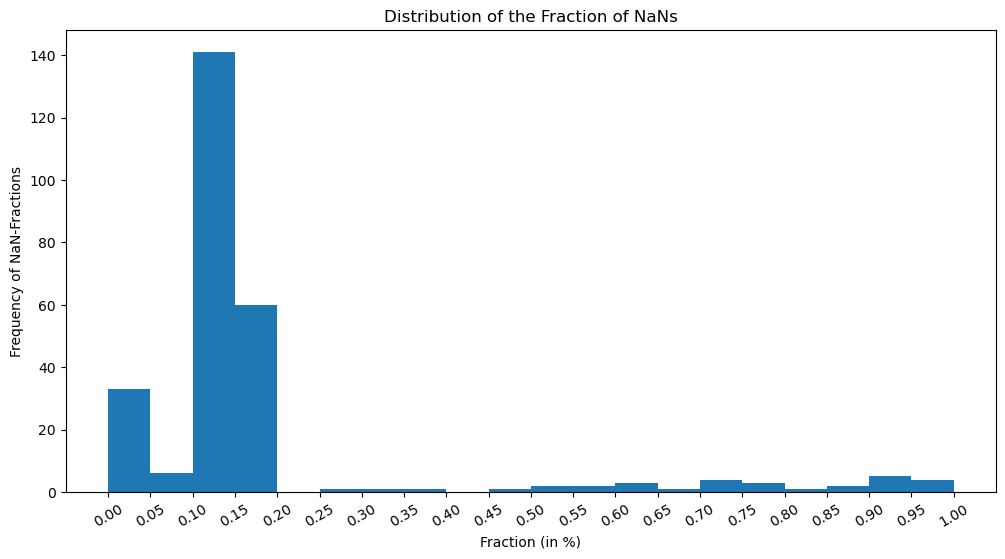

In [70]:
# Investigate patterns in the amount of missing data in each column.

nan_fractions = feature_info["nan_fraction"].sort_values(ascending=False)
plt.figure(figsize=(12,6))
bins = np.arange(0, nan_fractions.max()+0.01,0.05)


nan_fractions.plot.hist(bins=bins)
plt.ylabel("Frequency of NaN-Fractions")
plt.xlabel("Fraction (in %)")
plt.xticks(ticks=bins, rotation=30)
plt.title("Distribution of the Fraction of NaNs");

In [71]:
print("features with more than 20% of NaN values = ", sum(feature_info.nan_fraction > 0.2))

features with more than 20% of NaN values =  31


In [72]:
feature_info[feature_info.nan_fraction > 0.2][["Attribute", "nan_fraction"]].sort_values(by="nan_fraction", ascending = False)

,Attribute,nan_fraction
265,TITEL_KZ,0.997576
44,D19_TELKO_ONLINE_DATUM,0.990796
31,D19_BANKEN_OFFLINE_DATUM,0.977911
40,D19_TELKO_ANZ_12,0.962713
33,D19_BANKEN_ONLINE_QUOTE_12,0.949245
28,D19_BANKEN_ANZ_12,0.933252
41,D19_TELKO_ANZ_24,0.927052
51,D19_VERSI_ANZ_12,0.921532
43,D19_TELKO_OFFLINE_DATUM,0.919092
29,D19_BANKEN_ANZ_24,0.891025


only 31. Since NaNs need to be imputed otherwise, these features will be dropped

In [73]:
# CLEANING NaNs
azdias_clean = azdias_clean.drop(columns = feature_info[feature_info.nan_fraction > 0.2]["Attribute"].values, axis=1)
assert azdias.shape[1] - 31 == azdias_clean.shape[1], "wrong column count azdias"
#feature_info = feature_info[feature_info.nan_fraction <= 0.2]
#assert feature_info.shape[0] == azdias_clean.shape[1], "Mismatch df's"

---------

### Clean NaNs by rows

In [74]:
na_per_sample = azdias_clean.isna().sum(axis=1)
na_per_sample.describe()

count    891221.000000
mean         27.405499
std          64.259220
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         210.000000
dtype: float64

In [75]:
print("80% quartile ", np.quantile(na_per_sample, 0.80), "i.e. approx. {:,} samples have more NaNs".format(round(len(na_per_sample)*0.20)))
print("85% quartile ", np.quantile(na_per_sample, 0.85), "i.e. approx. {:,} samples have more NaNs".format(round(len(na_per_sample)*0.15)))
print("90% quartile ", np.quantile(na_per_sample, 0.90), "i.e. approx. {:,} samples have more NaNs".format(round(len(na_per_sample)*0.10)))
print("95% quartile ", np.quantile(na_per_sample, 0.95), "i.e. approx. {:,} samples have more NaNs".format(round(len(na_per_sample)*0.05)))
print("99% quartile ", np.quantile(na_per_sample, 0.99), "i.e. approx. {:,} samples have more NaNs".format(round(len(na_per_sample)*0.01)))

80% quartile  7.0 i.e. approx. 178,244 samples have more NaNs
85% quartile  63.0 i.e. approx. 133,683 samples have more NaNs
90% quartile  195.0 i.e. approx. 89,122 samples have more NaNs
95% quartile  207.0 i.e. approx. 44,561 samples have more NaNs
99% quartile  207.0 i.e. approx. 8,912 samples have more NaNs


There is quite a leap of nan count between the 80% and 85% quantile, let's check these

threshold of NaN counts: 10


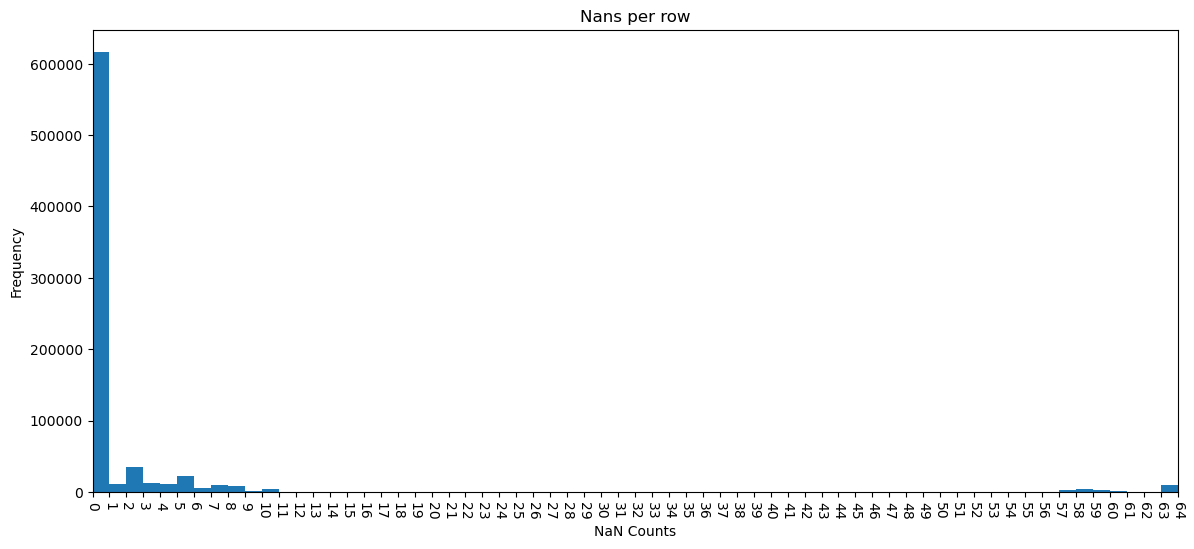

In [76]:
# checking quantiles to find a reasonable threshold:

bins=np.arange(0, na_per_sample.sort_values().max()+1, 1)
na_per_sample.sort_values().plot.hist(bins=bins, figsize=(14,6))
plt.xticks(bins,rotation=270)
plt.xlim(0,64)
plt.xlabel("NaN Counts")
plt.ylabel("Frequency")
plt.title("Nans per row"); 

# chose 10
threshold_q = 10

print("threshold of NaN counts:", threshold_q)

In [77]:
sum(na_per_sample.sort_values(ascending=False) > 10)/azdias_clean.shape[0]

0.17381435132251147

In [78]:
1 - sum(na_per_sample.sort_values(ascending=False) > 10)/azdias_clean.shape[0]

0.8261856486774886

10 NaNs will be chosen as the threshold to drop a row. This is equal to dropping 17.3% of the data

In [79]:
# CLEANING Drop by row NanCount > thresh
mask_drop = na_per_sample > threshold_q
azdias_clean =  azdias_clean.loc[~mask_drop,:].reset_index(drop=True)

In [80]:
azdias_clean.shape[0] / azdias.shape[0]

0.8261856486774886

---------------------------

### Categorical Features (Encoding)

Numeric features are mostly ordinal, will be assumed that the spacing between the different values is linear, which is most likely not the case most of the time - this applies to most of the data

Categorical features need to be examined in more depth. Either one-hot encoded is necessary (individual columns for each level); or they need to be excluded in the subsequent analysis

In [81]:
feature_info[feature_info.type == "categorical"]

,Attribute,Description,nan_vals_int,valid_vals,type,nan_count_cleaned,nan_fraction,original_nans,nan_dff
4,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical,257113,0.288495,257113,0
7,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical,4854,0.005446,4854,0
8,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical,0,0.000000,0,0
11,LP_FAMILIE_FEIN,familytyp fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
12,LP_FAMILIE_GROB,familytyp rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
15,LP_STATUS_FEIN,social status fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
16,LP_STATUS_GROB,social status rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
21,AGER_TYP,best-ager typology,[-1],"[0, 1, 2, 3]",categorical,677503,0.760196,0,677503
24,ANREDE_KZ,gender,"[-1, 0]","[1, 2]",categorical,0,0.000000,0,0
26,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,[-1],"[1, 2, 3, 4, 5, 6, 7, 8, 9]",categorical,558337,0.626485,98979,459358


LP_STATUS_FEIN	and LP_STATUS_GROB differ only in their detailedness. I will drop the former and re-encode the latter using the information in the attributes excel file

Exactly the same applies to LP_FAMILE_FEIN and _GROB

By doing so and applying one hot encoding later, we will have fewer dimensions/columns in the final df

In [82]:
azdias_clean.drop("LP_STATUS_FEIN",axis = 1, inplace=True)

In [83]:
azdias_clean.drop("LP_FAMILIE_FEIN",axis = 1, inplace=True)
#customers.drop("LP_STATUS_FEIN",axis = 1, inplace=True)
#feature_info = feature_info[feature_info.Attribute != "LP_STATUS_FEIN"]

In [84]:
azdias_clean.LP_STATUS_GROB.unique()

array([ 1.,  2.,  4.,  5.,  3., nan])

In [85]:
azdias_clean.LP_FAMILIE_GROB.unique()

array([ 3.,  1., nan,  5.,  2.,  4.])

In [86]:
feature_info[feature_info.type == "categorical"]

,Attribute,Description,nan_vals_int,valid_vals,type,nan_count_cleaned,nan_fraction,original_nans,nan_dff
4,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical,257113,0.288495,257113,0
7,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical,4854,0.005446,4854,0
8,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical,0,0.000000,0,0
11,LP_FAMILIE_FEIN,familytyp fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
12,LP_FAMILIE_GROB,familytyp rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
15,LP_STATUS_FEIN,social status fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
16,LP_STATUS_GROB,social status rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
21,AGER_TYP,best-ager typology,[-1],"[0, 1, 2, 3]",categorical,677503,0.760196,0,677503
24,ANREDE_KZ,gender,"[-1, 0]","[1, 2]",categorical,0,0.000000,0,0
26,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,[-1],"[1, 2, 3, 4, 5, 6, 7, 8, 9]",categorical,558337,0.626485,98979,459358


In [87]:
# re-encoding the feature NATIONALITAET_KZ into a binary, by summarizing "foreign sounding" and "assimilated names"
azdias_clean["NATIONALITAET_KZ"] = azdias_clean["NATIONALITAET_KZ"].map({1:0, 2:1, 3:1, np.nan: np.nan})
azdias_clean["NATIONALITAET_KZ"].value_counts()

NATIONALITAET_KZ
0.0    616098
1.0     89234
Name: count, dtype: int64

In [88]:
# additionally, I am going to drop the features GFK_URLAUBERTYP and GEBAEUDETYP, to keep the dimensionality low
azdias_clean.drop(["GFK_URLAUBERTYP", "GEBAEUDETYP"], axis=1, inplace=True)
#feature_info = feature_info[feature_info.Attribute != "GFK_URLAUBERTYP"]
#feature_info = feature_info[feature_info.Attribute != "GEBAEUDETYP"]

In [89]:
feature_info[feature_info.type == "categorical"]

,Attribute,Description,nan_vals_int,valid_vals,type,nan_count_cleaned,nan_fraction,original_nans,nan_dff
4,D19_KONSUMTYP,consumption type,False,"[1, 2, 3, 4, 5, 6, 9]",categorical,257113,0.288495,257113,0
7,GFK_URLAUBERTYP,vacation habits,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",categorical,4854,0.005446,4854,0
8,GREEN_AVANTGARDE,Green avantgarde,False,"[0, 1]",categorical,0,0.000000,0,0
11,LP_FAMILIE_FEIN,familytyp fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
12,LP_FAMILIE_GROB,familytyp rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",categorical,77792,0.087287,4854,72938
15,LP_STATUS_FEIN,social status fine,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
16,LP_STATUS_GROB,social status rough,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",categorical,4854,0.005446,4854,0
21,AGER_TYP,best-ager typology,[-1],"[0, 1, 2, 3]",categorical,677503,0.760196,0,677503
24,ANREDE_KZ,gender,"[-1, 0]","[1, 2]",categorical,0,0.000000,0,0
26,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,[-1],"[1, 2, 3, 4, 5, 6, 7, 8, 9]",categorical,558337,0.626485,98979,459358


In [90]:
# re-encode binary variables to 0 and 1 
azdias_clean["ANREDE_KZ"] = azdias_clean["ANREDE_KZ"].map({1:0, 2:1})
azdias_clean["VERS_TYP"] = azdias_clean["VERS_TYP"].map({1:0, 2:1, np.nan: np.nan}) 
azdias_clean["OST_WEST_KZ"] = azdias_clean["OST_WEST_KZ"].map({"0":0, "W":1, np.nan: np.nan}) 

-----------

### Cleaning Function

In [211]:
def clean_data(df, feature_info, nan_col_thresh = 0.2, nan_row_thresh=10):
    """ clean df according to above analysis/EDA and return a cleaned df """
    
    # align columns in df and feature_info
    missing_cols = df.columns[~(df.columns.isin(feature_info.Attribute))]

    # exclude the 3 customer data specific cols, before dropping
    missing_cols = missing_cols[missing_cols!="CUSTOMER_GROUP"]
    missing_cols = missing_cols[missing_cols!="PRODUCT_GROUP"]
    missing_cols = missing_cols[missing_cols!="ONLINE_PURCHASE"]

    # drop the columns in the original df, which are not in the feature_info df (i.e. unknown features)
    df_clean = df.drop(missing_cols, axis=1)

    # check
    #assert df_clean.columns.isin(feature_info.Attribute.unique()).sum() == \
    #len(feature_info.Attribute.unique()) == len(df_clean.columns), "mismatch or inconsistency"

    # drop CAMEO_DEU -> same order of execution as abvoe 
    #df_clean.drop("CAMEO_DEU_2015",axis = 1, inplace=True) ### DELETE, NOT NECESSARY DUE TO WORKFLOW! (not in feature_info anymore, dropped by design)
    
    # transform invalid values to NaNs
    df_clean, NaN_dict = invalid_vals_to_nan(df_clean)

    # cleaning NaNs per col according to investigation in EDA:
    df_clean = df_clean.drop(columns = feature_info[feature_info.nan_fraction > nan_col_thresh]["Attribute"].values, axis=1)

    # cleaning NaNs per sample/row according to investigation in EDA:
    na_per_sample = df_clean.isna().sum(axis=1) # NaN per row
    mask_drop = na_per_sample > nan_row_thresh
    df_clean =  df_clean.loc[~mask_drop,:]
    
    # drop selected categorical cols, since coarses substitutes will be used (smaller feature space)
    df_clean.drop("LP_FAMILIE_FEIN",axis = 1, inplace=True)
    df_clean.drop("LP_STATUS_FEIN",axis = 1, inplace=True)
    df_clean.drop(["GFK_URLAUBERTYP", "GEBAEUDETYP"], axis=1, inplace=True)


    # re-encoding of categorical features
    ## from 3 to 1 value:
    df_clean["NATIONALITAET_KZ"] = df_clean["NATIONALITAET_KZ"].map({1:0, 2:1, 3:1, np.nan: np.nan})
    ## re-encode binary variables to 0 and 1:
    df_clean["ANREDE_KZ"] = df_clean["ANREDE_KZ"].map({1:0, 2:1})
    df_clean["VERS_TYP"] = df_clean["VERS_TYP"].map({1:0, 2:1, np.nan: np.nan}) 
    df_clean["OST_WEST_KZ"] = df_clean["OST_WEST_KZ"].map({"0":0, "W":1, np.nan: np.nan}) 

    
    # Lastly, reset index
    df_clean.reset_index(drop=True)

    return df_clean

In [92]:
# test 
# load in the data
azdias_test = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
azdias_test_clean = clean_data(azdias_test, feature_info) # get test data

# tests azdias
assert azdias_test_clean.shape == azdias_clean.shape, "shapes do not match"
assert azdias_clean.isna().sum().sum() == azdias_test_clean.isna().sum().sum(), "NaN counts do not match"

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\274458381.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias_test = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [93]:
# test customers
customers_test = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers_test_clean = clean_data(customers_test, feature_info) # get test data
assert customers_test_clean.shape[1] == azdias_test_clean.shape[1] + 3, "should be 3 cols more in customer df"

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\3457377550.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers_test = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [94]:
print(round((azdias_clean.isnull().sum().sum() / (azdias_clean.shape[0]*azdias_clean.shape[1])), 3)*100,
      "%  fraction of NaNs in cleaned azdias df")

print(round((customers_test_clean.isnull().sum().sum() / (customers_test_clean.shape[0]*customers_test_clean.shape[1])), 3)*100,
      "%  fraction of NaNs in cleaned customer df")

0.4 %  fraction of NaNs in cleaned azdias df
0.3 %  fraction of NaNs in cleaned customer df


-----------

### One hot encode categorical Features

In [95]:
def preprocess_categorical_vars(df, feature_info):
    """
    get all MULTI-Level categorical columns in feature info df - binary have already been encoded to 0 and 1.
    One hot Encode the ones that are as well in the other df
    return a df with one hot encoded categorical variables
    """
    relevant_columns = feature_info[(feature_info.type == "categorical") & (feature_info.valid_vals.apply(lambda x: len(x) >= 2))].Attribute.values
    categorical_columns = df.columns[df.columns.isin(relevant_columns)]
    df_categorical = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)
    
    return df_categorical

In [96]:
check_cols = azdias_clean.columns[azdias_clean.columns.isin(feature_info[(feature_info.type == "categorical") & (feature_info.valid_vals.apply(lambda x: len(x) >= 2))].Attribute.values)]
check_cols

Index(['CJT_GESAMTTYP', 'FINANZTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_GROB',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP',
       'VERS_TYP', 'ZABEOTYP', 'ANREDE_KZ'],
      dtype='object')

In [97]:
azdias_clean.shape

(736314, 236)

In [98]:
azdias_cat = preprocess_categorical_vars(azdias_clean, feature_info)
print(azdias_cat.shape)
azdias_cat.iloc[:,224:].isnull().sum() # check, shouldnt be any nans

(736314, 255)


ALTERSKATEGORIE_GROB    0
CJT_GESAMTTYP_2.0       0
CJT_GESAMTTYP_3.0       0
CJT_GESAMTTYP_4.0       0
CJT_GESAMTTYP_5.0       0
CJT_GESAMTTYP_6.0       0
FINANZTYP_2.0           0
FINANZTYP_3.0           0
FINANZTYP_4.0           0
FINANZTYP_5.0           0
FINANZTYP_6.0           0
GREEN_AVANTGARDE_1.0    0
LP_FAMILIE_GROB_2.0     0
LP_FAMILIE_GROB_3.0     0
LP_FAMILIE_GROB_4.0     0
LP_FAMILIE_GROB_5.0     0
LP_STATUS_GROB_2.0      0
LP_STATUS_GROB_3.0      0
LP_STATUS_GROB_4.0      0
LP_STATUS_GROB_5.0      0
NATIONALITAET_KZ_1.0    0
SHOPPER_TYP_1.0         0
SHOPPER_TYP_2.0         0
SHOPPER_TYP_3.0         0
VERS_TYP_1.0            0
ZABEOTYP_2.0            0
ZABEOTYP_3.0            0
ZABEOTYP_4.0            0
ZABEOTYP_5.0            0
ZABEOTYP_6.0            0
ANREDE_KZ_1             0
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

---------
### 1.1 Feature Scaling and Imputation

Scaling is **pivotal** to:
- Use PCA for dimensionality reduction, because diagonalizing the covariance matrix requires the variance of all features to be of same scale, otherwise featues with large variance domiante the results
- Subsequently apply Kmeans for clustering later. Since the principal components are of the same scale, we can use Kmeans without concerns. Kmeans uses Euclidean distance to assess the variance within and between clusters, hence scaling of the input features matters - note: if we would use the original features as input for the Kmeans algorithm, we would in general need to scale them too.

In [99]:
def scale_and_impute(df):
    
    '''
    INPUT: azdias dataframe
    OUTPUT: a scaled and imputed dataframe. NaNs of categorical features are imputed with the mode.
            All numerical and ordinal features are transformed into standardized data.
            NaNs of ordinal or numerical features are imputed with the scaled mean, i.e. 0
            
            a dictionary "features_scalers" with keys as the features that were scaled and values as the  
            scaler objects; to transform the customer data later with the scaling parameters 
            of the general population - i.e. without the need to refit the data
            
            a dictionary "categorical_imputation" with keys as the categorical features that were imputed and
            values as the mode that was used to impute them
    '''
    
    # saving all scaled features in a list, to apply the (fit) scalers later to transform the customer data
    features_scalers = {}
    
    scaled_df = df.copy()
    
    # finding the features in the dataframe, that are numerical or ordinal and have NaNs
    nan_cols = df.columns[df.isnull().sum() != 0]
    # filter feature_info df accordingly
    feat_info_scaling = feature_info[feature_info["Attribute"].isin(nan_cols)].copy()
    standard_scaling_list = feat_info_scaling[feat_info_scaling["type"]=="ordinal"]["Attribute"].to_list()
    
    # scaling the features according to the mean and standard deviation that result by excluding NaNs
    for feature in standard_scaling_list:
        col_with_nans = scaled_df[feature].copy()
        col_without_nans = scaled_df[~scaled_df[feature].isnull()][feature].copy()
        col_scaler = StandardScaler().fit(col_without_nans.values.reshape(-1,1))
        col_with_nans = col_scaler.transform(col_with_nans.values.reshape(-1,1))
        
        # saving the feature and scaler to apply transformation later on the customer dataset
        features_scalers[feature] = col_scaler
        
        # imputing the NaNs with the scaled mean, which is 0
        nan_position = np.isnan(col_with_nans)
        col_with_nans[nan_position] = 0
        scaled_df[feature] = col_with_nans
        
        
    # filling the categorical features that have NaNs with the mode. 
    # The features and there modes are stored in a dict. The dict will be used to impute the categorical features of 
    # the customer df later
    categorical_imputation = {}
    
    impute_categorical = feat_info_scaling[feat_info_scaling["type"]=="categorical"]["Attribute"].to_list()
    for categorical in impute_categorical:
        scaled_df.fillna(scaled_df[categorical].mode()[0], inplace=True)
        categorical_imputation[categorical] = scaled_df[categorical].mode()[0]
        
        
    # scaling all other numerical resp. ordinal variables (i.e. features that are ordinal or numerical without NaNs)
    # same code as above, just indexing all other cols with no NaNs in feat_info_scaling dataframe and no imputation
    non_nan_cols = df.columns[df.isnull().sum() == 0]
    assert df.shape[1] == len(nan_cols) + len(non_nan_cols), "not all columnns considered in function!"
    
    feat_info_scaling = feature_info[feature_info["Attribute"].isin(non_nan_cols)].copy()
    standard_scaling_list_2 = feat_info_scaling[feat_info_scaling["type"]=="ordinal"]["Attribute"].to_list()
    
    for feature in standard_scaling_list_2:
        col = scaled_df[feature].copy()
        
        # we could actually use fit_transform here in one step. However, to safe the fitted scaler in a list,
        # I separate the steps again to make this step clear
        col_scaler = StandardScaler().fit(col.values.reshape(-1,1)) 
        col = col_scaler.transform(col.values.reshape(-1,1))
        scaled_df[feature] = col
        
        # saving the feature and scaler to apply transformation later on the customer dataset
        features_scalers[feature] = col_scaler
    
        
    return scaled_df, features_scalers, categorical_imputation

In [100]:
azdias_scaled, features_scalers, categorical_imputation = scale_and_impute(azdias_cat)
assert azdias_cat.shape == azdias_scaled.shape, "function output wrong"

In [101]:
# check if mean of all scaled features with imputed NaNs is approx. = 0 (standard_scaling_list)
list_stscaling = azdias_scaled.columns[azdias_scaled.columns.isin(feature_info[feature_info["type"]=="ordinal"]["Attribute"])]
azdias_scaled[list_stscaling].mean().apply(lambda x: format(x, "f"))

ANZ_HAUSHALTE_AKTIV            -0.000000
ANZ_HH_TITEL                    0.000000
ANZ_PERSONEN                   -0.000000
ANZ_TITEL                      -0.000000
BALLRAUM                        0.000000
EWDICHTE                       -0.000000
FINANZ_ANLEGER                 -0.000000
FINANZ_HAUSBAUER               -0.000000
FINANZ_MINIMALIST              -0.000000
FINANZ_SPARER                  -0.000000
FINANZ_UNAUFFAELLIGER           0.000000
FINANZ_VORSORGER               -0.000000
GEBAEUDETYP_RASTER              0.000000
GEBURTSJAHR                    -0.000000
HEALTH_TYP                     -0.000000
HH_EINKOMMEN_SCORE              0.000000
INNENSTADT                      0.000000
KBA05_ALTER1                    0.000000
KBA05_ALTER2                   -0.000000
KBA05_ALTER3                   -0.000000
KBA05_ALTER4                   -0.000000
KBA05_ANHANG                   -0.000000
KBA05_ANTG1                    -0.000000
KBA05_ANTG2                     0.000000
KBA05_ANTG3     

In [102]:
# check if std. of all scaled features with imputed NaNs is approx. = 1 (standard_scaling_list)
azdias_scaled[list_stscaling].std().apply(lambda x: format(x, "f"))

ANZ_HAUSHALTE_AKTIV            1.000001
ANZ_HH_TITEL                   0.997798
ANZ_PERSONEN                   1.000001
ANZ_TITEL                      1.000001
BALLRAUM                       0.999683
EWDICHTE                       0.999683
FINANZ_ANLEGER                 1.000001
FINANZ_HAUSBAUER               1.000001
FINANZ_MINIMALIST              1.000001
FINANZ_SPARER                  1.000001
FINANZ_UNAUFFAELLIGER          1.000001
FINANZ_VORSORGER               1.000001
GEBAEUDETYP_RASTER             0.999997
GEBURTSJAHR                    1.000001
HEALTH_TYP                     0.976961
HH_EINKOMMEN_SCORE             1.000001
INNENSTADT                     0.999683
KBA05_ALTER1                   1.000001
KBA05_ALTER2                   1.000001
KBA05_ALTER3                   1.000001
KBA05_ALTER4                   1.000001
KBA05_ANHANG                   1.000001
KBA05_ANTG1                    1.000001
KBA05_ANTG2                    1.000001
KBA05_ANTG3                    1.000001


In [103]:
# check is NaNs are still left
azdias_scaled.isnull().sum().sum()

0

---------
### 1.2 Dimensionality Reduction

to keep the size of the features space at bay, we can make use of dimensionality reduction techniques. Hence, we will use PCA in the following.

In [104]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

def implement_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the transformation
    
    INPUT: n_components - int - the number of principal components to create
           data - the data to be transformed
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with the new number of components
    '''
    
    pca = PCA(n_components, random_state=42)
    X_pca = pca.fit_transform(data)
    
    return pca, X_pca

# execute the function with 100 PCs

In [105]:
pca, azdias_pca = implement_pca(100, azdias_scaled)

In [106]:
azdias_pca.shape

(736314, 100)

In [107]:
pca.explained_variance_ratio_

array([0.08344945, 0.06849763, 0.04102064, 0.03285861, 0.02821833,
       0.02536349, 0.02400128, 0.0220136 , 0.02015661, 0.01919607,
       0.01667104, 0.01521486, 0.01438716, 0.01357991, 0.01284796,
       0.01240623, 0.01192511, 0.01088303, 0.01058115, 0.0103624 ,
       0.00979022, 0.00947165, 0.00912287, 0.00861252, 0.00829165,
       0.00810202, 0.00767194, 0.00742473, 0.00741131, 0.00703634,
       0.00693472, 0.00655798, 0.00648197, 0.00633099, 0.00625964,
       0.00616664, 0.00607474, 0.00592908, 0.00587026, 0.00575722,
       0.005671  , 0.0055579 , 0.00547387, 0.00535413, 0.00526187,
       0.00519209, 0.00511143, 0.00504369, 0.00497057, 0.00481192,
       0.00471792, 0.00470778, 0.00458918, 0.00450513, 0.00441709,
       0.0042859 , 0.00422337, 0.00419985, 0.00403691, 0.00402625,
       0.00400316, 0.00388899, 0.00387989, 0.00383423, 0.00373696,
       0.00371266, 0.00369225, 0.00364486, 0.00359978, 0.00356677,
       0.00352371, 0.00349537, 0.00344815, 0.00341588, 0.00334

In [108]:
def plot_pca_variance(pca_fitted, size=(14,10)):
    n_components = len(pca_fitted.explained_variance_ratio_)
    ind = np.arange(n_components)
    values = pca.explained_variance_ratio_ # ratio of explained variance

    cum_values = np.cumsum(values) # cumulative explained variance
    
    bins = np.arange(0, n_components)

    plt.figure(figsize=size)
    plt.bar(range(n_components), values, alpha = 0.5, align="center", label="explained variance per component")
    plt.step(range(n_components), cum_values, where="mid", label="cumulative explained variance")
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel("Principal Component Index")
    plt.xticks(ticks=bins, labels = bins+1, fontsize=7, rotation=90)
    plt.legend(loc = "best");

    return values, cum_values
    

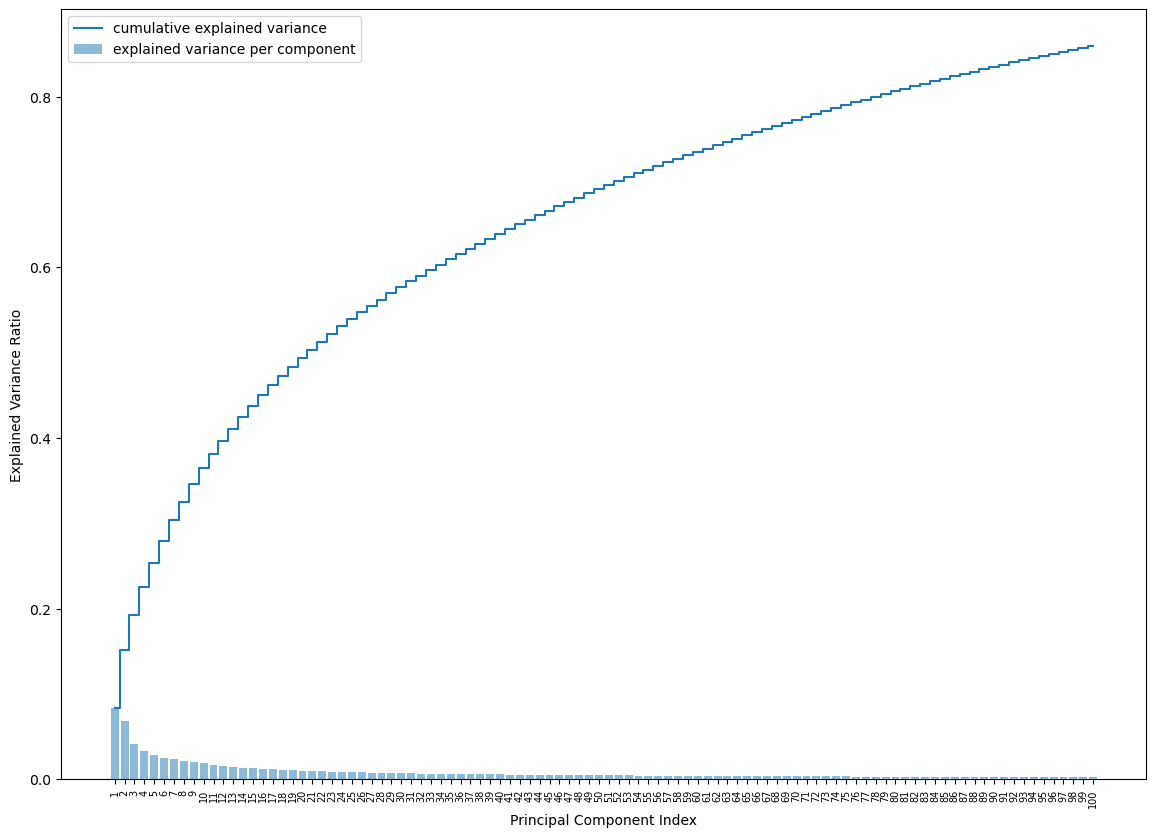

In [109]:
var, cumvar = plot_pca_variance(pca)

In [110]:
var

array([0.08344945, 0.06849763, 0.04102064, 0.03285861, 0.02821833,
       0.02536349, 0.02400128, 0.0220136 , 0.02015661, 0.01919607,
       0.01667104, 0.01521486, 0.01438716, 0.01357991, 0.01284796,
       0.01240623, 0.01192511, 0.01088303, 0.01058115, 0.0103624 ,
       0.00979022, 0.00947165, 0.00912287, 0.00861252, 0.00829165,
       0.00810202, 0.00767194, 0.00742473, 0.00741131, 0.00703634,
       0.00693472, 0.00655798, 0.00648197, 0.00633099, 0.00625964,
       0.00616664, 0.00607474, 0.00592908, 0.00587026, 0.00575722,
       0.005671  , 0.0055579 , 0.00547387, 0.00535413, 0.00526187,
       0.00519209, 0.00511143, 0.00504369, 0.00497057, 0.00481192,
       0.00471792, 0.00470778, 0.00458918, 0.00450513, 0.00441709,
       0.0042859 , 0.00422337, 0.00419985, 0.00403691, 0.00402625,
       0.00400316, 0.00388899, 0.00387989, 0.00383423, 0.00373696,
       0.00371266, 0.00369225, 0.00364486, 0.00359978, 0.00356677,
       0.00352371, 0.00349537, 0.00344815, 0.00341588, 0.00334

In [111]:
print(var < 0.01) # most of the PC's explain less than 1%
sum(var > 0.01)

[False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


20

In [112]:
cumvar # 100% is not reached, since we used less PC's than we have features in the original df

array([0.08344945, 0.15194708, 0.19296771, 0.22582633, 0.25404465,
       0.27940814, 0.30340942, 0.32542302, 0.34557963, 0.36477571,
       0.38144674, 0.3966616 , 0.41104876, 0.42462867, 0.43747663,
       0.44988286, 0.46180797, 0.472691  , 0.48327215, 0.49363455,
       0.50342477, 0.51289642, 0.52201929, 0.53063181, 0.53892346,
       0.54702548, 0.55469742, 0.56212215, 0.56953347, 0.57656981,
       0.58350453, 0.5900625 , 0.59654447, 0.60287546, 0.6091351 ,
       0.61530174, 0.62137647, 0.62730556, 0.63317582, 0.63893304,
       0.64460403, 0.65016194, 0.6556358 , 0.66098993, 0.6662518 ,
       0.67144389, 0.67655532, 0.68159902, 0.68656958, 0.69138151,
       0.69609943, 0.70080722, 0.70539639, 0.70990153, 0.71431862,
       0.71860452, 0.72282789, 0.72702774, 0.73106465, 0.7350909 ,
       0.73909406, 0.74298305, 0.74686294, 0.75069716, 0.75443412,
       0.75814678, 0.76183903, 0.76548389, 0.76908367, 0.77265044,
       0.77617415, 0.77966953, 0.78311768, 0.78653356, 0.78988

In [113]:
print(cumvar <0.6)
sum(cumvar <= 0.8)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


78

In [114]:
print(f"if we only explain 80% of variance, we can drop {azdias_scaled.shape[1] - sum(cumvar <= 0.8)} features")

if we only explain 80% of variance, we can drop 177 features


We can significantly reduce the feature space if we are satisfied with explaining 80% of the variance.

In [115]:
azdias_reduced = azdias_pca[:,:80].copy()
azdias_reduced.shape

(736314, 80)

---------
### 1.3 Clustering

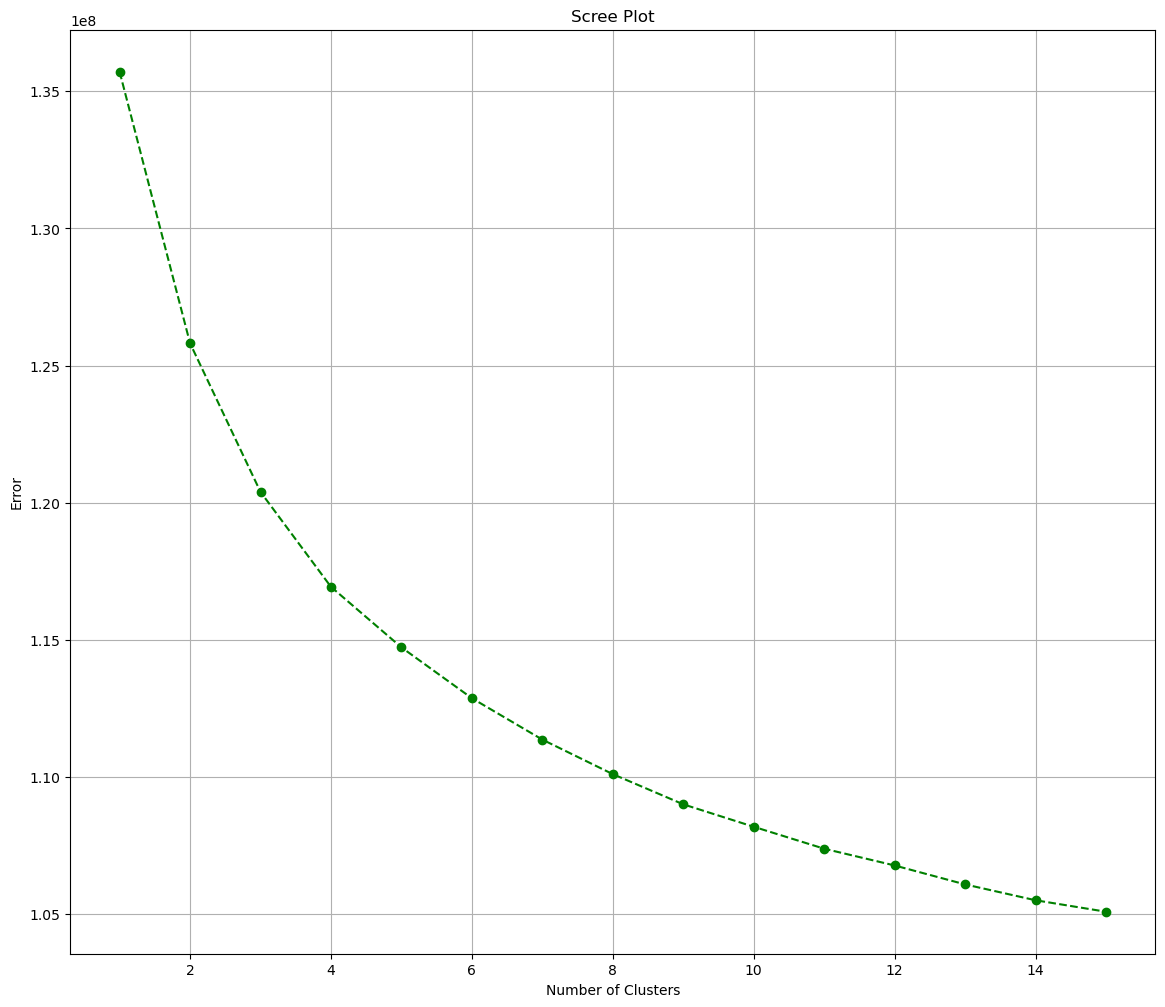

In [116]:
def perform_kmeans_ntimes(df, n_clusters=15, rseed=42, size=(14,12), iterations_kemans=3): 
    """ run kmeans and plot scores for different number of clusters | return scores """
    scores = []
    for k in range(1, n_clusters+1):
        kmeans_model = KMeans(k, random_state=rseed, n_init=iterations_kemans)
        kmeans_fit = kmeans_model.fit(df)
        scores.append(abs(round(kmeans_model.score(df), 2)))

    ncluster = list(range(1, n_clusters+1))
    plt.figure(figsize=size)
    plt.plot(ncluster, scores, linestyle="--", marker="o", color ="g")
    plt.title("Scree Plot")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Error")
    plt.grid()

    return scores


sse_within = perform_kmeans_ntimes(azdias_reduced)

In [117]:
sse_within

[135714868.95,
 125812742.68,
 120392003.64,
 116930985.62,
 114723325.24,
 112869802.15,
 111360267.55,
 110100649.34,
 109000088.47,
 108181539.22,
 107381330.11,
 106770504.05,
 106079889.96,
 105501670.4,
 105083389.25]

In [118]:
pd.Series(sse_within)/100000

0     1357.148689
1     1258.127427
2     1203.920036
3     1169.309856
4     1147.233252
5     1128.698022
6     1113.602676
7     1101.006493
8     1090.000885
9     1081.815392
10    1073.813301
11    1067.705040
12    1060.798900
13    1055.016704
14    1050.833893
dtype: float64

In [119]:
normalized_SSE_reduction = (pd.Series(sse_within[:-1]) - pd.Series(sse_within[1:])) / 100000
normalized_SSE_reduction # ne

0     99.021263
1     54.207390
2     34.610180
3     22.076604
4     18.535231
5     15.095346
6     12.596182
7     11.005609
8      8.185493
9      8.002091
10     6.108261
11     6.906141
12     5.782196
13     4.182812
dtype: float64

In [120]:
normalized_SSE_reduction[:6] 

0    99.021263
1    54.207390
2    34.610180
3    22.076604
4    18.535231
5    15.095346
dtype: float64

After looking at the scree plots, errors and change of errors when the data is split into more clusters, I decide to choose 6 clusters for the next steps of the analysis. I have a preference to choose rather less than more clusters, to make it easier to compare the general population with the customers in the following.

In [121]:
# refit kmeans with desired number of clusters 
n_clust = 6
 # this time, a few more kmeans iterations (n_init=30), to get a reliable/stable outcome
kmeans_algorithm = KMeans(n_clusters=n_clust, random_state=42, n_init=30).fit(azdias_reduced)

# label the population data 
clusters_azdias = kmeans_algorithm.predict(azdias_reduced)

In [122]:
np.unique(clusters_azdias)

array([0, 1, 2, 3, 4, 5])

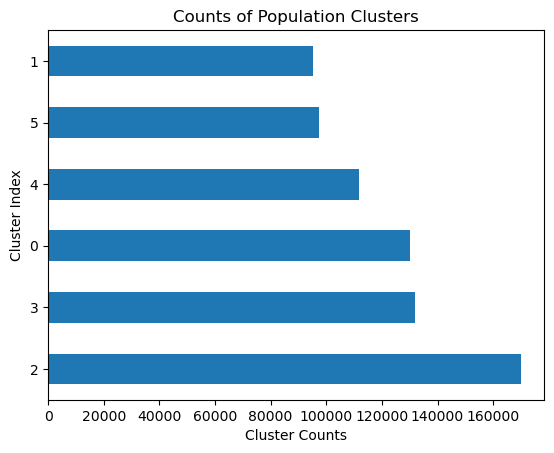

In [123]:
ax = pd.Series(clusters_azdias).value_counts().plot(kind='barh')
ax.set_xlabel('Cluster Counts')
ax.set_ylabel("Cluster Index")
ax.set_title("Counts of Population Clusters");

------------------

### 1.4 Clean, impute, scale, transform and cluster the Customer Data

In [124]:
# load dataset again
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\2833502490.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [125]:
# clean data
customers_clean = clean_data(customers, feature_info)

In [126]:
# one hot encode categorical vars
customers_cat = preprocess_categorical_vars(customers_clean, feature_info)

In [127]:
customers_cat.shape

(133951, 258)

In [128]:
# drop three additional customer columns, store them separately:
customer_info = customers_cat[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].copy()
customers_cat.drop(customers_cat[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']], axis=1, inplace=True)

In [129]:
assert customers_cat.shape[1] == azdias_cat.shape[1] == sum(customers_cat.columns == azdias_cat.columns), "population and customer data not consistent"

In [132]:
def scale_customers(customer_df, features_scalers):
    """
    scales customers (dataframe) by using the scalers fit on the general population
    returns the scaled data as a df
    """
    customers_scaled = customer_df.copy()
    for feature, scaler in features_scalers.items():
        customers_scaled[feature] = scaler.transform(customers_scaled[feature].values.reshape(-1,1))
        customers_scaled[feature].fillna(0, inplace=True) # impute NaNs with mean

    return customers_scaled

# scale and impute
customers_scaled = scale_customers(customers_cat, features_scalers)

# PCA transform
customers_pca = pca.transform(customers_scaled)
# align dimensions with azdias
customers_reduced = customers_pca[:,:80]

In [133]:
customers_reduced.shape

(133951, 80)

In [134]:
azdias_final = pd.DataFrame(azdias_reduced, columns = ["pc_" + str(x) for x in range(1,azdias_reduced.shape[1]+1)])
print("final shape of azdias df", azdias_final.shape)
customers_final = pd.DataFrame(customers_reduced, columns = ["pc_" + str(x) for x in range(1,azdias_reduced.shape[1]+1)])
print("final shape of customer df", customers_final.shape)

final shape of azdias df (736314, 80)
final shape of customer df (133951, 80)


In [135]:
azdias_final["clusters"] = clusters_azdias

In [136]:
azdias_final.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,pc_40,pc_41,pc_42,pc_43,pc_44,pc_45,pc_46,pc_47,pc_48,pc_49,pc_50,pc_51,pc_52,pc_53,pc_54,pc_55,pc_56,pc_57,pc_58,pc_59,pc_60,pc_61,pc_62,pc_63,pc_64,pc_65,pc_66,pc_67,pc_68,pc_69,pc_70,pc_71,pc_72,pc_73,pc_74,pc_75,pc_76,pc_77,pc_78,pc_79,pc_80,clusters
0,0.880550,5.044064,-4.816561,0.193835,-4.024866,-1.128950,2.446804,0.149724,-1.196402,3.688552,-0.444436,0.231865,-2.011671,-0.832206,-2.532425,0.048629,-0.001063,1.174569,0.750530,0.201419,1.994948,1.379496,5.059953,2.687892,-1.095010,1.303174,-0.114990,1.927829,1.645793,0.728083,-0.353953,0.621458,2.626352,-2.829197,1.135286,-0.675257,0.592854,-1.997528,1.584728,1.424059,-1.869077,1.450614,0.103911,-0.671300,-1.421423,0.736423,-1.099873,-1.504437,-0.167835,1.588604,0.319373,-0.216858,-0.669254,0.120085,0.685859,-1.075768,-1.966405,0.688635,1.370782,0.190916,-0.506740,-0.612492,-0.695424,0.407889,0.882928,-1.620629,-0.582819,2.189286,-1.150563,-1.138940,-0.345983,-1.051773,1.138829,0.606127,-0.384750,-1.598580,-1.638825,0.497688,0.553926,0.881110,0
1,2.301478,1.261279,1.399477,3.352733,4.863942,-3.049069,3.385816,-1.248552,0.565381,-1.624562,1.153870,0.903988,-2.262638,1.758869,1.797102,-1.092539,-0.642815,-0.733512,0.763766,-2.283083,-0.381664,-0.109485,1.109299,-0.768791,1.662799,1.338418,-1.209040,-0.098468,-1.677897,0.677450,0.391844,-0.489582,0.384880,-0.302040,0.326181,1.810340,1.112533,0.774946,0.240944,-0.746186,0.482757,-1.109396,-0.807837,-0.639706,1.296133,-0.000751,0.939899,-1.148066,-2.071874,-1.186364,-0.771034,0.373440,0.266635,1.574196,-0.005810,-0.228789,1.447447,0.314817,-0.540580,0.119920,0.439947,-0.123553,1.650682,0.232220,-1.070511,-0.480389,-0.702868,-1.177996,1.469947,-0.634705,0.041267,0.734544,0.524710,-0.475345,0.492796,-0.679580,0.096257,-0.999740,-0.412134,-0.776645,4
2,5.242642,-1.955012,1.270928,-0.779211,-1.216168,-2.298493,-0.739940,1.299139,-3.072265,0.691980,-1.511002,-0.998502,0.133920,0.770191,1.506574,0.855446,0.033250,0.031512,0.386835,1.425308,0.522320,0.157713,-0.331113,-2.541926,-0.869708,-2.449047,-4.539663,1.124329,-1.595799,0.637654,-1.736818,-0.692184,-0.422251,0.408224,0.144563,0.293470,-1.105124,1.341631,-1.048489,-1.699282,0.866749,0.400811,1.486174,0.710884,-1.281890,0.242307,-1.313605,1.307424,0.422767,-0.575318,-0.023284,1.404461,0.190259,0.394761,-0.045600,0.882179,0.104392,0.052078,0.665258,0.650400,0.989572,0.253422,1.261429,-1.242347,-0.344114,-1.304223,-0.602032,-0.161975,0.413115,-0.733115,-0.161560,-0.785596,0.393470,0.586552,1.822335,-0.536116,0.179366,0.278704,0.580846,-0.572471,2
3,1.674419,2.156946,-0.065373,-0.877272,2.822703,0.722216,-3.814908,1.167931,-3.229114,-2.486431,1.879110,0.770967,3.111488,-0.141623,-0.338090,-0.212524,-1.070127,1.805314,-2.682488,2.642109,2.641469,-0.229322,-0.021922,-0.798742,0.114892,1.689727,0.816351,-0.750844,-2.627474,0.637634,0.910657,-2.877586,-0.395656,-0.869173,-0.018354,2.108446,-2.296529,0.491567,-0.070209,0.240425,-2.197710,-1.001221,1.049933,1.812941,0.754554,0.270307,2.608193,-0.787618,-0.172235,1.297945,-1.885952,0.972144,0.254429,-0.856385,-0.289297,0.710057,0.401380,1.107012,-0.925428,-0.296765,2.460428,-0.690344,0.512806,-1.764304,-1.236892,0.403270,2.242332,0.945107,0.584228,-0.145536,0.360004,0.924118,0.772917,0.838649,-0.471699,-0.270391,-0.701390,-1.289882,-0.111998,-0.361895,4
4,3.564841,0.414476,-1.248271,1.572617,-0.238860,-1.907198,0.371874,-0.647512,-1.469335,-0.281400,-3.826834,-0.229084,-1.553511,-0.850642,1.636401,-1.148853,0.826220,0.765408,0.945957,-1.822264,0.425249,-0.411151,-1.663971,0.422097,0.433264,1.820981,-1.127268,-1.172648,-0.711677,1.167272,-1.405284,0.115017,-2.035354,0.435268,-1.693188,0.323939,-0.760247,-1.082683,-0.819705,0.268637,-1.089574,1.330072,-0.314679,0.615043,0.109015,1.986827,-2.341886,-0.125109,-0.039368,-

In [137]:
clusters_customers = kmeans_algorithm.predict(customers_reduced)
customers_final["clusters"] = clusters_customers
customers_final.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,pc_40,pc_41,pc_42,pc_43,pc_44,pc_45,pc_46,pc_47,pc_48,pc_49,pc_50,pc_51,pc_52,pc_53,pc_54,pc_55,pc_56,pc_57,pc_58,pc_59,pc_60,pc_61,pc_62,pc_63,pc_64,pc_65,pc_66,pc_67,pc_68,pc_69,pc_70,pc_71,pc_72,pc_73,pc_74,pc_75,pc_76,pc_77,pc_78,pc_79,pc_80,clusters
0,8.279225,-0.772006,1.871402,-2.050943,0.400360,1.264142,-3.605794,-1.803974,-1.409186,0.625787,-1.103188,-0.547084,-0.978834,-0.822383,-0.553795,-2.579312,0.550866,-1.396055,0.851402,2.380245,-1.066590,-0.576289,0.359591,0.008525,-1.787817,-0.187533,2.825612,0.742765,0.147204,-0.642525,-2.151634,-0.430421,0.532493,0.535557,1.671968,-0.661075,-0.945057,-1.883010,-0.389192,-1.041849,-0.696044,-0.831076,1.739751,-1.022683,-0.127771,-1.468746,-0.246679,0.535688,-0.132641,1.889085,-0.663863,0.136258,0.989117,0.465153,-0.470778,-0.225367,0.944245,0.208470,-0.795589,-0.399990,-0.789749,0.803172,0.121732,-0.175502,-1.459744,-1.259417,-0.150024,-0.002435,-0.318065,0.881694,0.530868,0.199656,-0.861080,1.116713,-0.043214,-0.787892,0.049783,-0.444541,0.925946,-0.765070,2
1,1.374782,2.326088,4.234908,-3.983185,0.012533,1.826981,-0.145228,5.289846,-3.019077,1.729500,-1.166482,1.637623,0.708593,-1.461835,0.741096,1.501641,0.250586,1.007898,-0.818884,-0.977034,0.871591,0.079899,-1.164121,0.329179,-1.643978,-1.480230,-1.473441,-2.222178,0.622777,-0.223960,1.574479,-0.573507,-1.629369,-0.960188,-0.552147,-0.337168,-1.388797,-0.111450,-0.431363,0.439444,1.058970,1.374052,0.814666,1.661959,-0.348420,-1.882186,0.658446,0.452202,0.671452,1.310145,-1.581685,-0.210675,-1.711645,-1.323300,0.270225,-0.694380,0.009001,-0.704810,-0.060934,-0.400269,0.753281,1.544514,0.485645,-1.019245,0.318967,0.053866,2.297832,0.721224,0.127304,-1.158007,-0.345161,-1.348332,0.517812,0.394670,-0.048618,0.957759,-0.411820,0.468955,-0.282884,0.154575,4
2,3.114677,-2.851916,2.335875,3.354579,-0.203480,-2.774956,-3.707957,-1.175240,-0.857031,-2.566536,-0.963801,1.909529,-1.278884,1.394088,0.895634,-0.965459,2.304702,-1.233183,1.865132,-2.710506,-0.740339,2.107585,-1.405833,-0.043384,-0.250327,0.398647,-2.895530,-0.786807,-1.148795,-1.921086,-0.309699,2.668840,-0.531968,1.269026,-0.513010,-0.069635,-2.721489,-0.874443,0.675502,0.306941,1.730367,0.372585,0.041250,0.881616,0.274505,0.223372,-0.150169,0.114013,-0.429805,-1.842870,-0.378480,-1.905609,0.276803,0.028624,1.156081,-0.940845,-1.338306,-3.172312,1.140649,-0.221024,0.304165,-0.542427,1.454551,0.830743,0.198902,-0.280216,-0.181476,-1.080824,-1.081741,-0.935276,1.999276,-0.779250,-0.528198,-1.347556,-0.830171,0.983954,-0.076875,-0.027768,-1.935224,0.368705,2
3,-1.993882,-1.176083,-1.797276,-2.859127,0.817580,1.904285,0.162041,-2.094781,-1.126524,0.971625,-1.740999,-2.218540,1.340158,3.166267,-1.850324,3.695021,0.728010,0.172867,1.838135,-1.028582,1.958604,0.389356,1.231086,-2.526024,0.309090,-0.085610,1.161797,-1.348117,-0.330148,-0.145480,-1.104612,-1.611088,-1.225457,-0.046769,-0.440359,-0.667091,0.235696,1.457979,-0.002030,0.104327,-0.687679,-0.241226,0.550911,1.229760,0.075557,0.917510,-0.748046,0.757944,-0.202112,-0.137994,0.685781,0.065852,1.654092,-1.387209,-1.047088,-1.609435,-0.779503,-0.713817,-1.355323,-0.413826,1.738632,0.572640,-0.553758,-0.818667,2.058300,0.424100,-2.470498,-0.073741,-0.491895,-0.348371,-1.401230,-1.028096,-1.455722,0.776428,0.554788,-0.144101,-0.079483,-0.378253,-0.008071,-0.150799,3
4,7.100803,5.802292,2.656925,1.175329,0.666889,1.649598,-2.955981,2.289328,-1.066282,-0.303890,-0.037490,-0.878344,-0.341222,-2.008485,-0.019746,-0.694987,-1.453755,1.113032,1.908328,0.857827,0.219838,-1.950356,-1.415328,1.741816,-1.019939,0.582204,0.727044,0.243404,-2.485529,0.515622,-1.333547,-1.100767,-0.236864,-0.848231,1.779080,0.778812,0.126112,-2.132977,0.354593,0.801968,-2.245953,0.815358,-1.398287,-1.474345,-0.288193,1.571966,1.

------------------

### 1.5 Comparison of General Population and Customer Data

In [138]:
azdias_cluster_fractions = (azdias_final["clusters"].value_counts() / azdias_final.shape[0]).sort_index()
azdias_cluster_fractions

clusters
0    0.176639
1    0.129530
2    0.230661
3    0.179233
4    0.151926
5    0.132010
Name: count, dtype: float64

In [139]:
customers_cluster_fractions = (customers_final["clusters"].value_counts() / customers_final.shape[0]).sort_index()
customers_cluster_fractions

clusters
0    0.027316
1    0.046920
2    0.460497
3    0.117916
4    0.307008
5    0.040343
Name: count, dtype: float64

In [140]:
cluster_fraction_comparison = customers_cluster_fractions - azdias_cluster_fractions
cluster_fraction_comparison

clusters
0   -0.149323
1   -0.082610
2    0.229836
3   -0.061317
4    0.155082
5   -0.091667
Name: count, dtype: float64

Take into account three additional columns of customers df => also for analysis => groupby and check

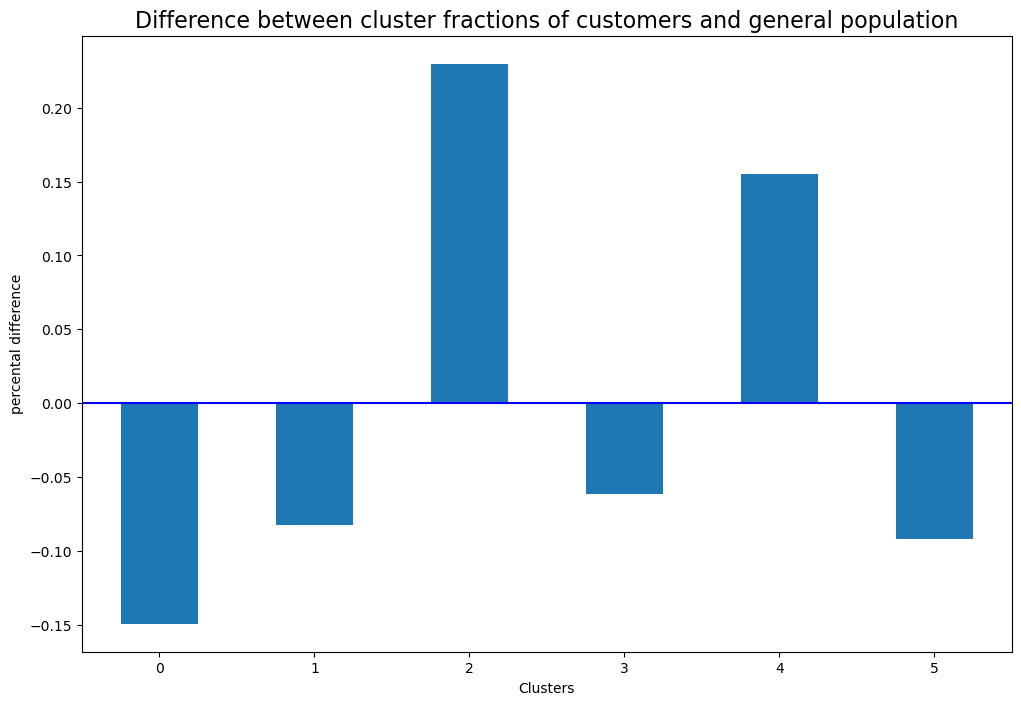

In [141]:
plt.figure(figsize=[12,8])
cluster_fraction_comparison.plot.bar()
plt.ylabel("percental difference")
plt.xlabel("Clusters")
plt.xticks(rotation=0)
plt.axhline(0, c='blue')
plt.title("Difference between cluster fractions of customers and general population", size=16);

In [142]:
cluster_fraction_comparison.sort_values()

clusters
0   -0.149323
5   -0.091667
1   -0.082610
3   -0.061317
4    0.155082
2    0.229836
Name: count, dtype: float64

In [143]:
print(round(sum(customers_cluster_fractions.iloc[[2,4]])*100,2), "% of all customers are either in cluster 2 or 4")

76.75 % of all customers are either in cluster 2 or 4


Clearly, Cluster 2 (relative frequency difference + 22%) and Cluster 4 (relative frequency difference + 15.5%) are overrepresented compared to the general population. Hence, individuals in the general population with similar characteristics to  customers that reside in one of these two clusters should be targeted in the context of a marketing campaign of the company. In other words, they can be assumed to be more likely to become customers. 

Cluster 0 is underrepresented with approximately -15%

------------------

### 1.6 Analysis of overrepresented Clusters

In order to understand what individuals are likely to become future customers of the company, one can analyze the overrepresented clusters by:
- Finding the most important Principal Components with the help of the cluster centroids (that is, a vector of means, one for each Principal Component in the cluster)
- looking at the feature weights of the Principal Components that influence the constitution of an overrepresented cluster the most. 
- Drawing conclusions by examining the sign and magniutde of the respective weight together with the scale and meaning of the original feature which it pertains to.

In [144]:
print(kmeans_algorithm.cluster_centers_.shape) # 6 cluster centers with 80 data points, each representing one of the 80 principal components

(6, 80)


In [145]:
# centroid of the overrepresented cluster 2
centroid_cluster2 = kmeans_algorithm.cluster_centers_[2]
centroid_cluster2 = pd.Series(centroid_cluster2, index=["pc_" + str(x) for x in range(1,azdias_reduced.shape[1]+1)])

# centroid of the overrepresented cluster 4
centroid_cluster4 = kmeans_algorithm.cluster_centers_[4]
centroid_cluster4 = pd.Series(centroid_cluster4, index=["pc_" + str(x) for x in range(1,azdias_reduced.shape[1]+1)])

In [146]:
centroid_cluster4.head(6)

pc_1    4.388145
pc_2    4.344378
pc_3    1.304284
pc_4    0.901864
pc_5    0.354818
pc_6    0.470186
dtype: float64

note, that we could as well compute the centroids manually, since they are just the PC means of the filtered pca-transformed data for a given cluster 

In [147]:
azdias_final[azdias_final["clusters"]==4].iloc[:,:6].mean(axis=0)

pc_1    4.385888
pc_2    4.349677
pc_3    1.302363
pc_4    0.902550
pc_5    0.354665
pc_6    0.469281
dtype: float64

In [150]:
def most_important_principal_components(centroid, n=10):
    """returns the most important principal components for a given cluster (centroid) by absolute value"""
    
    return centroid.loc[np.abs(centroid).sort_values(ascending=False).index[:n]]


PCs_cluster_4 = most_important_principal_components(centroid_cluster4)
PCs_cluster_4 

pc_1     4.388145
pc_2     4.344378
pc_3     1.304284
pc_4     0.901864
pc_9    -0.490666
pc_6     0.470186
pc_11    0.393582
pc_10    0.358915
pc_5     0.354818
pc_16    0.249356
dtype: float64

In [151]:
PCs_cluster_2 = most_important_principal_components(centroid_cluster2)
PCs_cluster_2

pc_1     3.367298
pc_2    -2.865723
pc_4    -1.200747
pc_3     0.874223
pc_9     0.479112
pc_5    -0.413071
pc_7    -0.381928
pc_10   -0.250954
pc_6    -0.228247
pc_17    0.195316
dtype: float64

In [152]:
print(len(PCs_cluster_2[PCs_cluster_2.index.isin(PCs_cluster_4.index)]))
PCs_cluster_2[PCs_cluster_2.index.isin(PCs_cluster_4.index)].index

8


Index(['pc_1', 'pc_2', 'pc_4', 'pc_3', 'pc_9', 'pc_5', 'pc_10', 'pc_6'], dtype='object')

The results are quite interesting. The following can be observed:
- 8 of the 10 most important PC's are similar in cluster 2 and 4
- The PC's that influence the clusters the most, i.e. that are most distant from zero, are obvsiously PC 1 and 2 (in line with the fact that both explained the largest part of variance in the data):
- In cluster 2, PC_1 = 3.7 and PC_2 = -2.865
- In cluster 4, PC_1 = 4.4 and PC_2 = 4.3

So, the centroids of the clusters exhibit the same sign for PC_1 (same for PC_3), but differ in direction w.r.t. to PC_2 (same for PC_4)!

Hence, only considering the first two PC's when comparing the two cluster centroids, they can be mainly distinguished by the direction of PC_2

In [154]:
def component_feature_weights(component):
    '''
    INPUT:
    component: an integer, that indicates the ith component for which the weights are to be inspected 
    
    OUTPUT:
    component_weights: an ordered pd.Series of the feature weights of the specific component 
    
    absolute_weight_importance: an ordered pd.Series comprising the 10 highest absolute values of the weights
                          
                          
    a vertical barplot that visualizes the 20 most important components
    '''
    component_weights_df = pd.DataFrame(pca.components_, columns=azdias_cat.columns)
    component_weights = component_weights_df.iloc[component-1].sort_values(ascending=False)
    
    absolute_weight_importance = np.abs(component_weights_df.iloc[component-1]).sort_values(ascending=False)[:10]
    
    plot_weights = pd.concat([component_weights[:10],component_weights[-10:]])
    plt.figure(figsize=(10,6))
    plot_weights.plot.barh()
    plt.xlabel("Weights of Features")
    plt.ylabel("Features")
    plt.title("Feature Importance of principal component {}".format(component), fontsize=14)
    plt.xticks(np.arange(np.min(plot_weights),np.max(plot_weights)+0.05,0.025), rotation=60)
    plt.grid(axis="x")
    plt.axvline(0, c='blue')
    plt.show();
    
    return component_weights[:5], component_weights[-5:], absolute_weight_importance

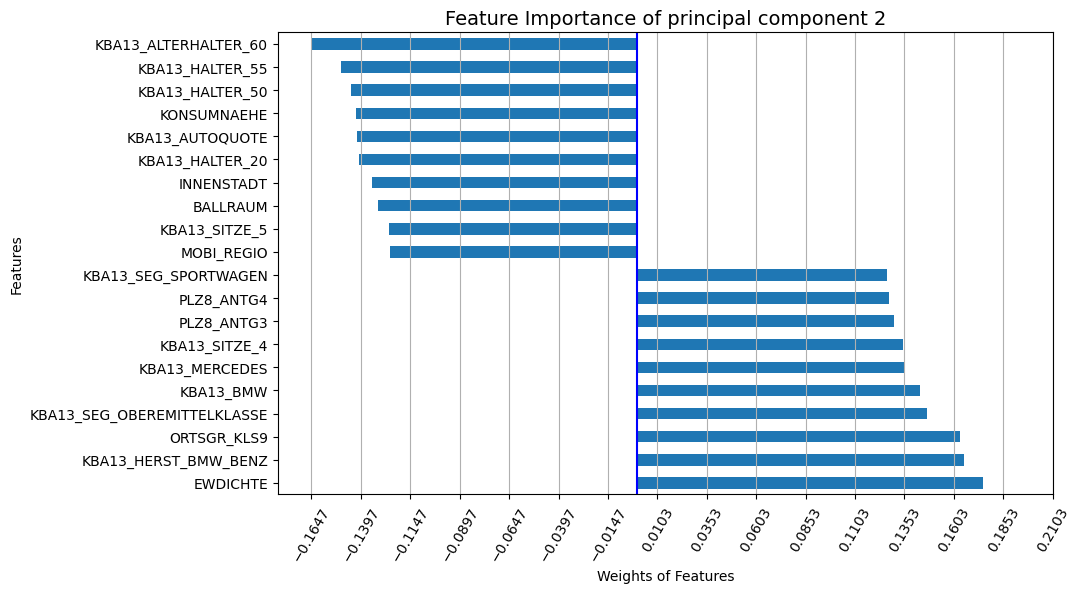

(EWDICHTE                       0.175042
 KBA13_HERST_BMW_BENZ           0.165387
 ORTSGR_KLS9                    0.163489
 KBA13_SEG_OBEREMITTELKLASSE    0.146549
 KBA13_BMW                      0.143214
 Name: 1, dtype: float64,
 KBA13_AUTOQUOTE        -0.141633
 KONSUMNAEHE            -0.142333
 KBA13_HALTER_50        -0.144865
 KBA13_HALTER_55        -0.149646
 KBA13_ALTERHALTER_60   -0.164706
 Name: 1, dtype: float64,
 EWDICHTE                       0.175042
 KBA13_HERST_BMW_BENZ           0.165387
 KBA13_ALTERHALTER_60           0.164706
 ORTSGR_KLS9                    0.163489
 KBA13_HALTER_55                0.149646
 KBA13_SEG_OBEREMITTELKLASSE    0.146549
 KBA13_HALTER_50                0.144865
 KBA13_BMW                      0.143214
 KONSUMNAEHE                    0.142333
 KBA13_AUTOQUOTE                0.141633
 Name: 1, dtype: float64)

In [155]:
component_feature_weights(2)

Again, for component 2, we cannot necessarily conclude that the features help distinguishing between customers and the general population (Both of the clusters are overrepresented). The component rather does indicate differences between cluster 2 and cluster 4.

However, the value of the component in cluster 4 (4.3) is of higher magnitude than in cluster 2 (-2.8), the latter being the most overrepresented cluster. So, i) it influences cluster 4 more and ii) there might even by a tendency that a negative value of the component could indicate that it is more likely that the individual is a (going to be) a customer.

In [158]:
def cluster_2_or_4(row):
    """ assign value, depending if a datapoint is in one of the overrepresented clusters (2, 4) or another one"""
    if row == 2:
        return 2
    elif row == 4:
        return 4
    else:
        return 0

In [159]:
azdias_pc_sample = azdias_final.sample(frac = 0.05, random_state=101) # downsample for plotting
azdias_pc_sample["cluster_2_4"] = azdias_pc_sample["clusters"].apply(cluster_2_or_4)

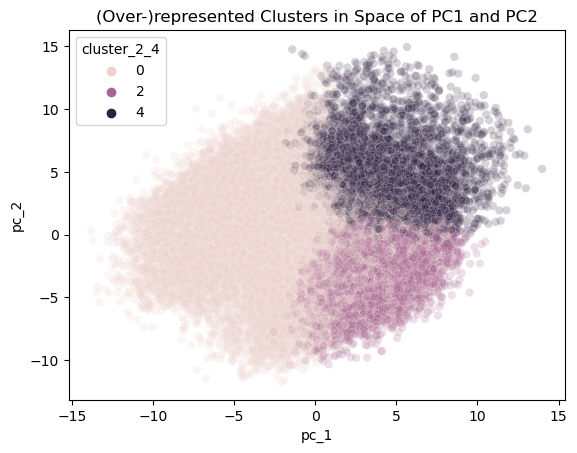

In [160]:
sns.scatterplot(data=azdias_pc_sample, x="pc_1", y="pc_2", hue="cluster_2_4", alpha=0.2)
plt.title("(Over-)represented Clusters in Space of PC1 and PC2");

As we can see, mainly PC_1 helps to distinguish the overrepresented cluster from the rest. As we move to the right on the x-axis, cluster 2 and 4 become more prevalent.

Now, let's have a closer look at PC1

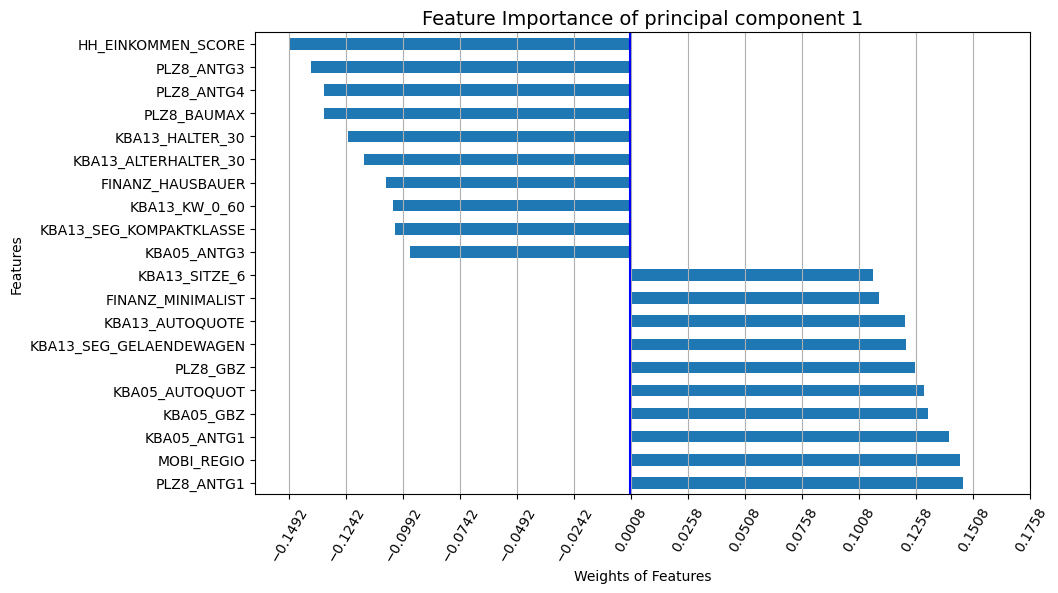

(PLZ8_ANTG1        0.146303
 MOBI_REGIO        0.144966
 KBA05_ANTG1       0.140178
 KBA05_GBZ         0.130986
 KBA05_AUTOQUOT    0.128959
 Name: 0, dtype: float64,
 KBA13_HALTER_30      -0.123393
 PLZ8_BAUMAX          -0.134073
 PLZ8_ANTG4           -0.134098
 PLZ8_ANTG3           -0.139695
 HH_EINKOMMEN_SCORE   -0.149242
 Name: 0, dtype: float64,
 HH_EINKOMMEN_SCORE    0.149242
 PLZ8_ANTG1            0.146303
 MOBI_REGIO            0.144966
 KBA05_ANTG1           0.140178
 PLZ8_ANTG3            0.139695
 PLZ8_ANTG4            0.134098
 PLZ8_BAUMAX           0.134073
 KBA05_GBZ             0.130986
 KBA05_AUTOQUOT        0.128959
 PLZ8_GBZ              0.125203
 Name: 0, dtype: float64)

In [206]:
component_feature_weights(1)

To understand the constitution of the overrepresented clusters, one should analyze the feature weights of PC1. Above are the 10 highest weights plotted and listed (5 most positive, and 5 most negative ones)

E.g. PLZ8_ANTG1 is the feature with the highest positive weights. In the same vein, KBA13_HALTER_30 exhibits the largest negative weight

In [250]:
azdias_scaled.PLZ8_ANTG1.value_counts()

PLZ8_ANTG1
-0.256580    255897
 0.770559    209065
-1.283718    180302
 1.797697     82492
-2.310857      5313
 0.000000      3245
Name: count, dtype: int64

In [252]:
azdias_scaled.KBA13_HALTER_30.value_counts()

KBA13_HALTER_30
-0.053416    302381
-0.972485    145727
 0.865654    141455
 1.784723     85142
-1.891554     61609
Name: count, dtype: int64

All features have been scaled (if not categorical) so that they have zero mean and unit variance.

**Interpretation:**

if PLZ8_ANTG1 > 0 (highest positive weight), then it contributes to a positive value of PC1, i.e. that an individual is assigned to cluster 2 or 4 (and vice versa) - given that both cluster centers have a positive value of approx. 4 for PC1 

if HH_EINKOMMEN_SCORE (highest negative  weight) > 0, then it contributes to a negative value of PC1, i.e. that an individual is *not* assigned to cluster 2 or 4 (and vice versa)

Consequently w.r.t. "PLZ8_ANTG1", which represents the "number of 1-2 family houses in the PLZ8" (i.e. relates to location) => the higher the share of 1-2 family houses, the more likely it is that an individual is assigned to an overrepresented cluster.


SImilarly, HH_EINKOMMEN_SCORE is denoting "estimated household net income ". Hence, if the estimated net income of the house hold is very high (smallest value of original scale, i.e. below mean), the same logic applies. and the individual is more likely to end up in an overrepresented cluster (a high value indicates a low income, hence, the feature weight with the negative sign multiplied by a value above mean of 0 yields a negative result and therefore the contribution to PC1 is negative)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

------------------

### Load Data and Distribution of Response

In [161]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [162]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\stefa\AppData\Local\Temp\ipykernel_20040\4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [163]:
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

In [221]:
mailout_train.RESPONSE.isnull().sum()

0

In [164]:
mailout_train.RESPONSE.value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

highly skewed dataset

In [317]:
mailout_train.RESPONSE.value_counts() / mailout_train.RESPONSE.value_counts().sum()

RESPONSE
0    0.987617
1    0.012383
Name: count, dtype: float64

In [318]:
mailout_train.RESPONSE.value_counts()[0] / mailout_train.RESPONSE.value_counts().sum() # majority classifier

0.9876169638284996

a "Majority classifier" (= always predicting 0) would be correct approx. 98.76% (accuracy) of the time

The challenge will be to find the positives, hence Recall ( =TP / [TP + FN] ) should be in particular considered when assessing model performance (which the majority classifier obviously would not find)

------------------

### Prepare Training data

First, adjusting cleaning function a bit:

In [224]:
def clean_data(df, feature_info, nan_col_thresh = 0.2, nan_row_thresh=10, train_data=False):
    """ clean df according to above analysis/EDA and return a cleaned df """
    
    # align columns in df and feature_info
    missing_cols = df.columns[~(df.columns.isin(feature_info.Attribute))]

    # exclude the 3 customer data specific cols, before dropping
    missing_cols = missing_cols[missing_cols!="CUSTOMER_GROUP"]
    missing_cols = missing_cols[missing_cols!="PRODUCT_GROUP"]
    missing_cols = missing_cols[missing_cols!="ONLINE_PURCHASE"]

    if train_data == True:
        missing_cols = missing_cols[missing_cols!="RESPONSE"]
        

    # drop the columns in the original df, which are not in the feature_info df (i.e. unknown features)
    df_clean = df.drop(missing_cols, axis=1)

    # check
    #assert df_clean.columns.isin(feature_info.Attribute.unique()).sum() == \
    #len(feature_info.Attribute.unique()) == len(df_clean.columns), "mismatch or inconsistency"

    # drop CAMEO_DEU -> same order of execution as abvoe 
    #df_clean.drop("CAMEO_DEU_2015",axis = 1, inplace=True) ### DELETE, NOT NECESSARY DUE TO WORKFLOW! (not in feature_info anymore, dropped by design)
    
    # transform invalid values to NaNs
    df_clean, NaN_dict = invalid_vals_to_nan(df_clean)

    # cleaning NaNs per col according to investigation in EDA:
    df_clean = df_clean.drop(columns = feature_info[feature_info.nan_fraction > nan_col_thresh]["Attribute"].values, axis=1)

    # cleaning NaNs per sample/row according to investigation in EDA:
    na_per_sample = df_clean.isna().sum(axis=1) # NaN per row
    mask_drop = na_per_sample > nan_row_thresh
    df_clean =  df_clean.loc[~mask_drop,:]
    
    # drop selected categorical cols, since coarses substitutes will be used (smaller feature space)
    df_clean.drop("LP_FAMILIE_FEIN",axis = 1, inplace=True)
    df_clean.drop("LP_STATUS_FEIN",axis = 1, inplace=True)
    df_clean.drop(["GFK_URLAUBERTYP", "GEBAEUDETYP"], axis=1, inplace=True)


    # re-encoding of categorical features
    ## from 3 to 1 value:
    df_clean["NATIONALITAET_KZ"] = df_clean["NATIONALITAET_KZ"].map({1:0, 2:1, 3:1, np.nan: np.nan})
    ## re-encode binary variables to 0 and 1:
    df_clean["ANREDE_KZ"] = df_clean["ANREDE_KZ"].map({1:0, 2:1})
    df_clean["VERS_TYP"] = df_clean["VERS_TYP"].map({1:0, 2:1, np.nan: np.nan}) 
    df_clean["OST_WEST_KZ"] = df_clean["OST_WEST_KZ"].map({"0":0, "W":1, np.nan: np.nan}) 
    
    # Lastly, reset index
    df_clean.reset_index(drop=True)

    if train_data == True:
        response = df_clean["RESPONSE"]
        df_clean.drop("RESPONSE",axis = 1, inplace=True)
        return df_clean, response

    return df_clean

In [537]:
def prepare_data(df, f_scalers, kmeans_object, t_data=True, index_components=80):
    """
    performs all cleaning, imputation, scaling and transformation steps for data which is not the customer data or population data
    t_data parameter enables to distinguish if a response column is included or not
    """
    # clean data
    if t_data==True:
        df_clean, response = clean_data(df, feature_info, train_data=t_data)
    else:
        df_clean = clean_data(df, feature_info, train_data=t_data)

    # one hot encode categorical vars
    df_cat = preprocess_categorical_vars(df_clean, feature_info)

    # checks:
    assert df_cat.shape[1] == azdias_cat.shape[1] == sum(df_cat.columns == azdias_cat.columns)

    # scale and impute
    df_scaled = scale_customers(df_cat, f_scalers)

    # PCA tranform
    df_pca = pca.transform(df_scaled)
    # align dimensions with azdias
    df_reduced = df_pca[:,:index_components]

    # get kmeans clusters
    clusters_df = kmeans_algorithm.predict(df_reduced)

    # set up final dataframe
    df_final = pd.DataFrame(df_reduced, columns = ["pc_" + str(x) for x in range(1,azdias_reduced.shape[1]+1)])

    # add clusters
    df_final["clusters"] = clusters_df

    # concat response col if applicable
    if t_data==True:
        assert df_final.shape[0] == len(response), "rows of final df do not match length of response series"
        # reset both indices before concatenation
        df_final.reset_index(drop=True, inplace=True)
        response.reset_index(drop=True, inplace=True)

        # concat
        df_final = pd.concat([df_final, response], axis=1)

    return df_final

In [587]:
train_df = prepare_data(mailout_train, f_scalers=features_scalers, kmeans_object=kmeans_algorithm, t_data=True)

In [588]:
train_df.RESPONSE.value_counts() / train_df.shape[0] # relative frequency similar to before cleaning

RESPONSE
0    0.987682
1    0.012318
Name: count, dtype: float64

In [589]:
train_df.iloc[0:10, [0, 1,2,3,-3,-2,-1]] # visual check of the columns

,pc_1,pc_2,pc_3,pc_4,pc_80,clusters,RESPONSE
0,-2.136587,5.835275,5.527632,-1.562961,-0.641319,1,0
1,4.152906,-5.800898,0.150070,-2.397711,0.332930,2,0
2,-0.310045,-1.274779,4.921729,4.179601,-0.447623,5,0
3,8.668925,9.319480,5.358243,-1.047423,-1.354412,4,0
4,2.646945,5.816289,3.662140,4.574847,-0.471439,4,0
5,-6.221690,6.144341,2.676856,-5.238143,-0.697431,1,0
6,3.138828,-3.375401,3.612302,-0.506452,-0.909548,2,0
7,5.518991,-3.224678,1.311614,-0.498706,-0.716498,2,0
8,0.492249,-7.354780,2.582567,-0.691792,0.087132,2,0
9,4.163909,-2.071560,3.235725,-1.337012,-0.449297,2,0


------------------

### Naive Cluster based Prediction

To get a feel how the derived clusters (predicted by using the kmeans algorithm which was fit on the general population) provide information w.r.t. the train data and to have one more "benchmark" that assists thinking conceptually about the prediction set up we have, I will introduce another naive prediciton.

In [345]:
groupby_results = train_df.groupby(["clusters", "RESPONSE"])["RESPONSE"].count().unstack()
groupby_results

RESPONSE,0,1
clusters,,
0,1118,5
1,2214,19
2,13141,180
3,5339,71
4,6799,101
5,4746,40


In [346]:
share_not_customers= groupby_results.iloc[:,0] / groupby_results.sum(axis=1)
share_customers = groupby_results.iloc[:,1] / groupby_results.sum(axis=1)

In [349]:
groupby_results["share_not_customers"] = share_not_customers
groupby_results["share_customers"] = share_customers
groupby_results.sort_values(by="share_customers")

RESPONSE,0,1,share_not_customers,share_customers
clusters,,,,
0,1118,5,0.995548,0.004452
5,4746,40,0.991642,0.008358
1,2214,19,0.991491,0.008509
3,5339,71,0.986876,0.013124
2,13141,180,0.986488,0.013512
4,6799,101,0.985362,0.014638


Cluster 2 and 4 have the highest relative frequency of customers (REPONSE == 1), which is coherent with previous results

In [322]:
def cluster_2_or_4_pred(row):
    """ if row in cluster 2 or 4, predict customer, else not"""
    if (row == 2) or (row == 4):
        return 1
    else:
        return 0

In [329]:
def print_naive_cluster_pred(df, response_var, preds=False):
    cluster_preds = df["clusters"].apply(cluster_2_or_4_pred).copy()
    print(classification_report(df[response_var].values, cluster_preds.values))

    if  preds == True:
        return cluster_preds

In [330]:
preds = print_naive_cluster_pred(train_df, "RESPONSE", preds=True)

              precision    recall  f1-score   support

           0       0.99      0.40      0.57     33357
           1       0.01      0.68      0.03       416

    accuracy                           0.41     33773
   macro avg       0.50      0.54      0.30     33773
weighted avg       0.98      0.41      0.57     33773



A naive prediction using cluster 2 and 4 as a basis to predict if the individual is a customers leads - as expected - to a high recall (68%) and low precision (only 1%).

The recall of 68% is coherent with the previous results, where we noted that cluster 2 and 4 comprise about 76.75 % of all customers w.r.t. the customer data 

Since the recall in this context reflects just the sum of relative frequencies of the true positives in cluster 2 and 4:

In [356]:
groupby_results.iloc[[2,4],1].sum() / groupby_results.iloc[:,1].sum()

0.6754807692307693

It is naturally quite high.

However, precision is low, due to the skewness of the distributions inside the clusters:

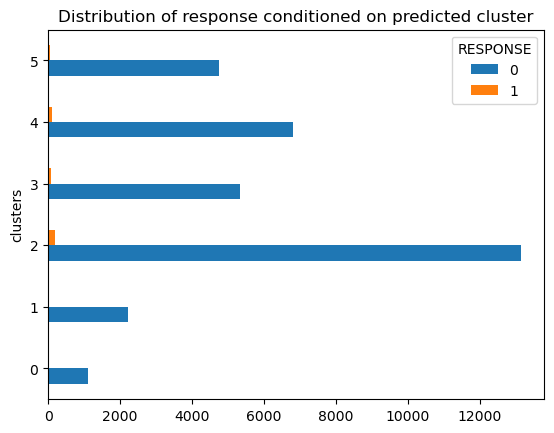

In [362]:
groupby_results.iloc[:,:2].plot.barh()
plt.title("Distribution of response conditioned on predicted cluster");

On top of this, cluster 4 and 2 are the largest clusters - even though the "customers" are overrepresented.

All in all, the deduced clusters help in identifying potential customers, but cannot be used alone to reliably predict them.

If we were to use the outlined naive prediction, we would target most of the potential customers, but as well a considerable amount of individuals which did not become customers in the end, indicated by the relatively low precision in the classification of 1% which accounts for the False Positives (= TP / [TP + FP]) as well as the high counts where RESPONSE = 0 in cluster 2 and 4.

Next, let's try out a few supervised learning algorithms, to see how good we can do using more sophisticated methods!
(I will keep the "clusters" column when training these models, since it might support the classifiers to find the Positives and discriminate them from the Negatives)

------------------

### Supervised Learning Algorithms

A selection of supervised learning algorithms will be applied using default parameters. 

The one with the best AUC score will be fine-tuned and the best hyperparameter configuration used to make predictions on the test data at the end

In [507]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

Note, since all cleaning, imputation, scaling and transformations were performed using solely information w.r.t. the general population, we can use the prepared training data without any concerns of data leakage in the following. 

In other words: no information of the validation sets in cross validation is integrated when the classifiers are fit on the remaining data.

In [376]:
train_df.iloc[0:10, [0, 1,2,3,-3,-2,-1]] # check again first and last columns

,pc_1,pc_2,pc_3,pc_4,pc_80,clusters,RESPONSE
0,-2.136587,5.835275,5.527632,-1.562961,-0.641319,1,0
1,4.152906,-5.800898,0.150070,-2.397711,0.332930,2,0
2,-0.310045,-1.274779,4.921729,4.179601,-0.447623,5,0
3,8.668925,9.319480,5.358243,-1.047423,-1.354412,4,0
4,2.646945,5.816289,3.662140,4.574847,-0.471439,4,0
5,-6.221690,6.144341,2.676856,-5.238143,-0.697431,1,0
6,3.138828,-3.375401,3.612302,-0.506452,-0.909548,2,0
7,5.518991,-3.224678,1.311614,-0.498706,-0.716498,2,0
8,0.492249,-7.354780,2.582567,-0.691792,0.087132,2,0
9,4.163909,-2.071560,3.235725,-1.337012,-0.449297,2,0


In [533]:
clfrs = {
    "GaussianNB": GaussianNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(), 
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier()
}

In [544]:
def CV_train_predict_classifiers(df, clfrs, p_grid={}, folds=3):

    """
    Use CV cross validation to fit and predict with various classifiers. Returns a df, consisting of the classifiers used and their scores
    """
    
    X = df.drop(columns="RESPONSE").copy()
    y = df["RESPONSE"].copy()  

    scores = []

    for k,clf in clfrs.items():
        grid_search = GridSearchCV(estimator=clf, param_grid=p_grid, scoring='roc_auc', cv=folds)
        grid_search.fit(X,y)
        scores.append(grid_search.best_score_)

    results_df = pd.DataFrame(
        {
            "Clfer": list(clfrs.keys()),
            "auc":scores
        }        
    )
    
    return results_df       

results = CV_train_predict_classifiers(train_df, clfrs)
results

In [529]:
results

,Clfer,auc
0,GaussianNB,0.563765
1,LogisticRegression,0.578956
2,RandomForestClassifier,0.531675
3,AdaBoostClassifier,0.527874
4,GradientBoostingClassifier,0.522496


Logistic Regression appears to yield the best results! It will be the algorithm used for fine-tuning

In [601]:
# split data again
X = train_df.drop(columns="RESPONSE").copy()
y = train_df["RESPONSE"].copy()  
# grid taken from:
# https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

param_grid = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['liblinear']}
logReg = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, scoring='roc_auc', verbose=True, n_jobs=-1)
logReg.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=True)

In [602]:
logReg.best_params_

{'C': 78.47599703514607, 'penalty': 'l1', 'solver': 'liblinear'}

In [618]:
logReg.best_score_

0.5766351878089628

The best Score of the logistic Regression model is not particularly high.

This indicates that one should not necessarily feed the transformed data to the supervised learning algorithm. Instead of using the largely reduced dataset, where multiple rows and columns have been dropped and PCA rotation been applied